In [1]:
from tqdm import tqdm
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime

from scipy.stats import norm, describe
from scipy.optimize import curve_fit

import math
from scipy.special import gamma, jv

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

## Loading MSD of Trends and Seasonality

In [2]:
MSD_trend_df = pd.read_csv("../MSD_trends.csv", index_col = 0) 
MSD_seasonality_df = pd.read_csv("../MSD_seasonality.csv", parse_dates=True, index_col = 0) 

In [3]:
regions = ['CAR','Region I', 'Region II', 
 'Region III', 'NCR', 'Region IV-A',
 'Region VI', 'Region VII', 'Region VIII', 
 'Region IX', 'Region X', 'Region XI',
 'Region XII', 'Region XIII', 'ARMM']
MSD_trend_df = MSD_trend_df[regions]
MSD_seasonality_df = MSD_seasonality_df[regions]
MSD_seasonality_df

CAR  Region I  Region II  Region III       NCR  Region IV-A  \
1     0.000710  0.001288   0.000789    0.002225  0.809848     0.003978   
2     0.000722  0.001344   0.000819    0.002086  0.783116     0.003689   
3     0.000705  0.001176   0.000804    0.001558  0.750473     0.002687   
4     0.000743  0.001179   0.000798    0.001368  0.668244     0.002190   
5     0.000832  0.001432   0.000914    0.001995  0.735111     0.003138   
...        ...       ...        ...         ...       ...          ...   
4158       NaN       NaN        NaN         NaN       NaN          NaN   
4159       NaN       NaN        NaN         NaN       NaN          NaN   
4160       NaN       NaN        NaN         NaN       NaN          NaN   
4161       NaN       NaN        NaN         NaN       NaN          NaN   
4162       NaN       NaN        NaN         NaN       NaN          NaN   

      Region VI  Region VII  Region VIII  Region IX  Region X  Region XI  \
1      0.000906    0.001138     0.000791   0.000458  0.000476   0.000514   
2      0.000913    0.001092     0.000801   0.000452  0.000460   0.000496   
3      0.000757    0.000833     0.000703   0.000412  0.000419   0.000433   
4      0.000676    0.000688     0.000687   0.000365  0.000381   0.000471   
5      0.000844    0.001018     0.000823   0.000417  0.000455   0.000478   
...         ...         ...          ...        ...       ...        ...   
4158        NaN         NaN          NaN        NaN       NaN        NaN   
4159        NaN         NaN          NaN        NaN       NaN        NaN   
4160        NaN         NaN          NaN        NaN       NaN        NaN   
4161        NaN         NaN          NaN        NaN       NaN        NaN   
4162        NaN         NaN          NaN        NaN       NaN        NaN   

      Region XII  Region XIII      ARMM  
1       0.000538     0.000525  0.000336  
2       0.000481     0.000486  0.000321  
3       0.000445     0.000509  0.000287  
4       0.000447     0.000514  0.000281  
5       0.000442     0.000546  0.000318  
...          ...          ...       ...  
4158         NaN          NaN       NaN  
4159         NaN          NaN       NaN  
4160         NaN          NaN       NaN  
4161         NaN          NaN       NaN  
4162         NaN          NaN       NaN  

[4162 rows x 15 columns]

In [4]:
# MSD_trend_df = MSD_trend_df.drop(['NCR'], axis=1)
# MSD_seasonality_df = MSD_seasonality_df.drop(['NCR'], axis=1)

In [5]:
def plot_in_log():
    plt.grid(alpha = 0.5)
    plt.xscale("log")
    plt.yscale("log")
    
def plot_labels():
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")


Plotting MSD: 15it [00:00, 81.22it/s]


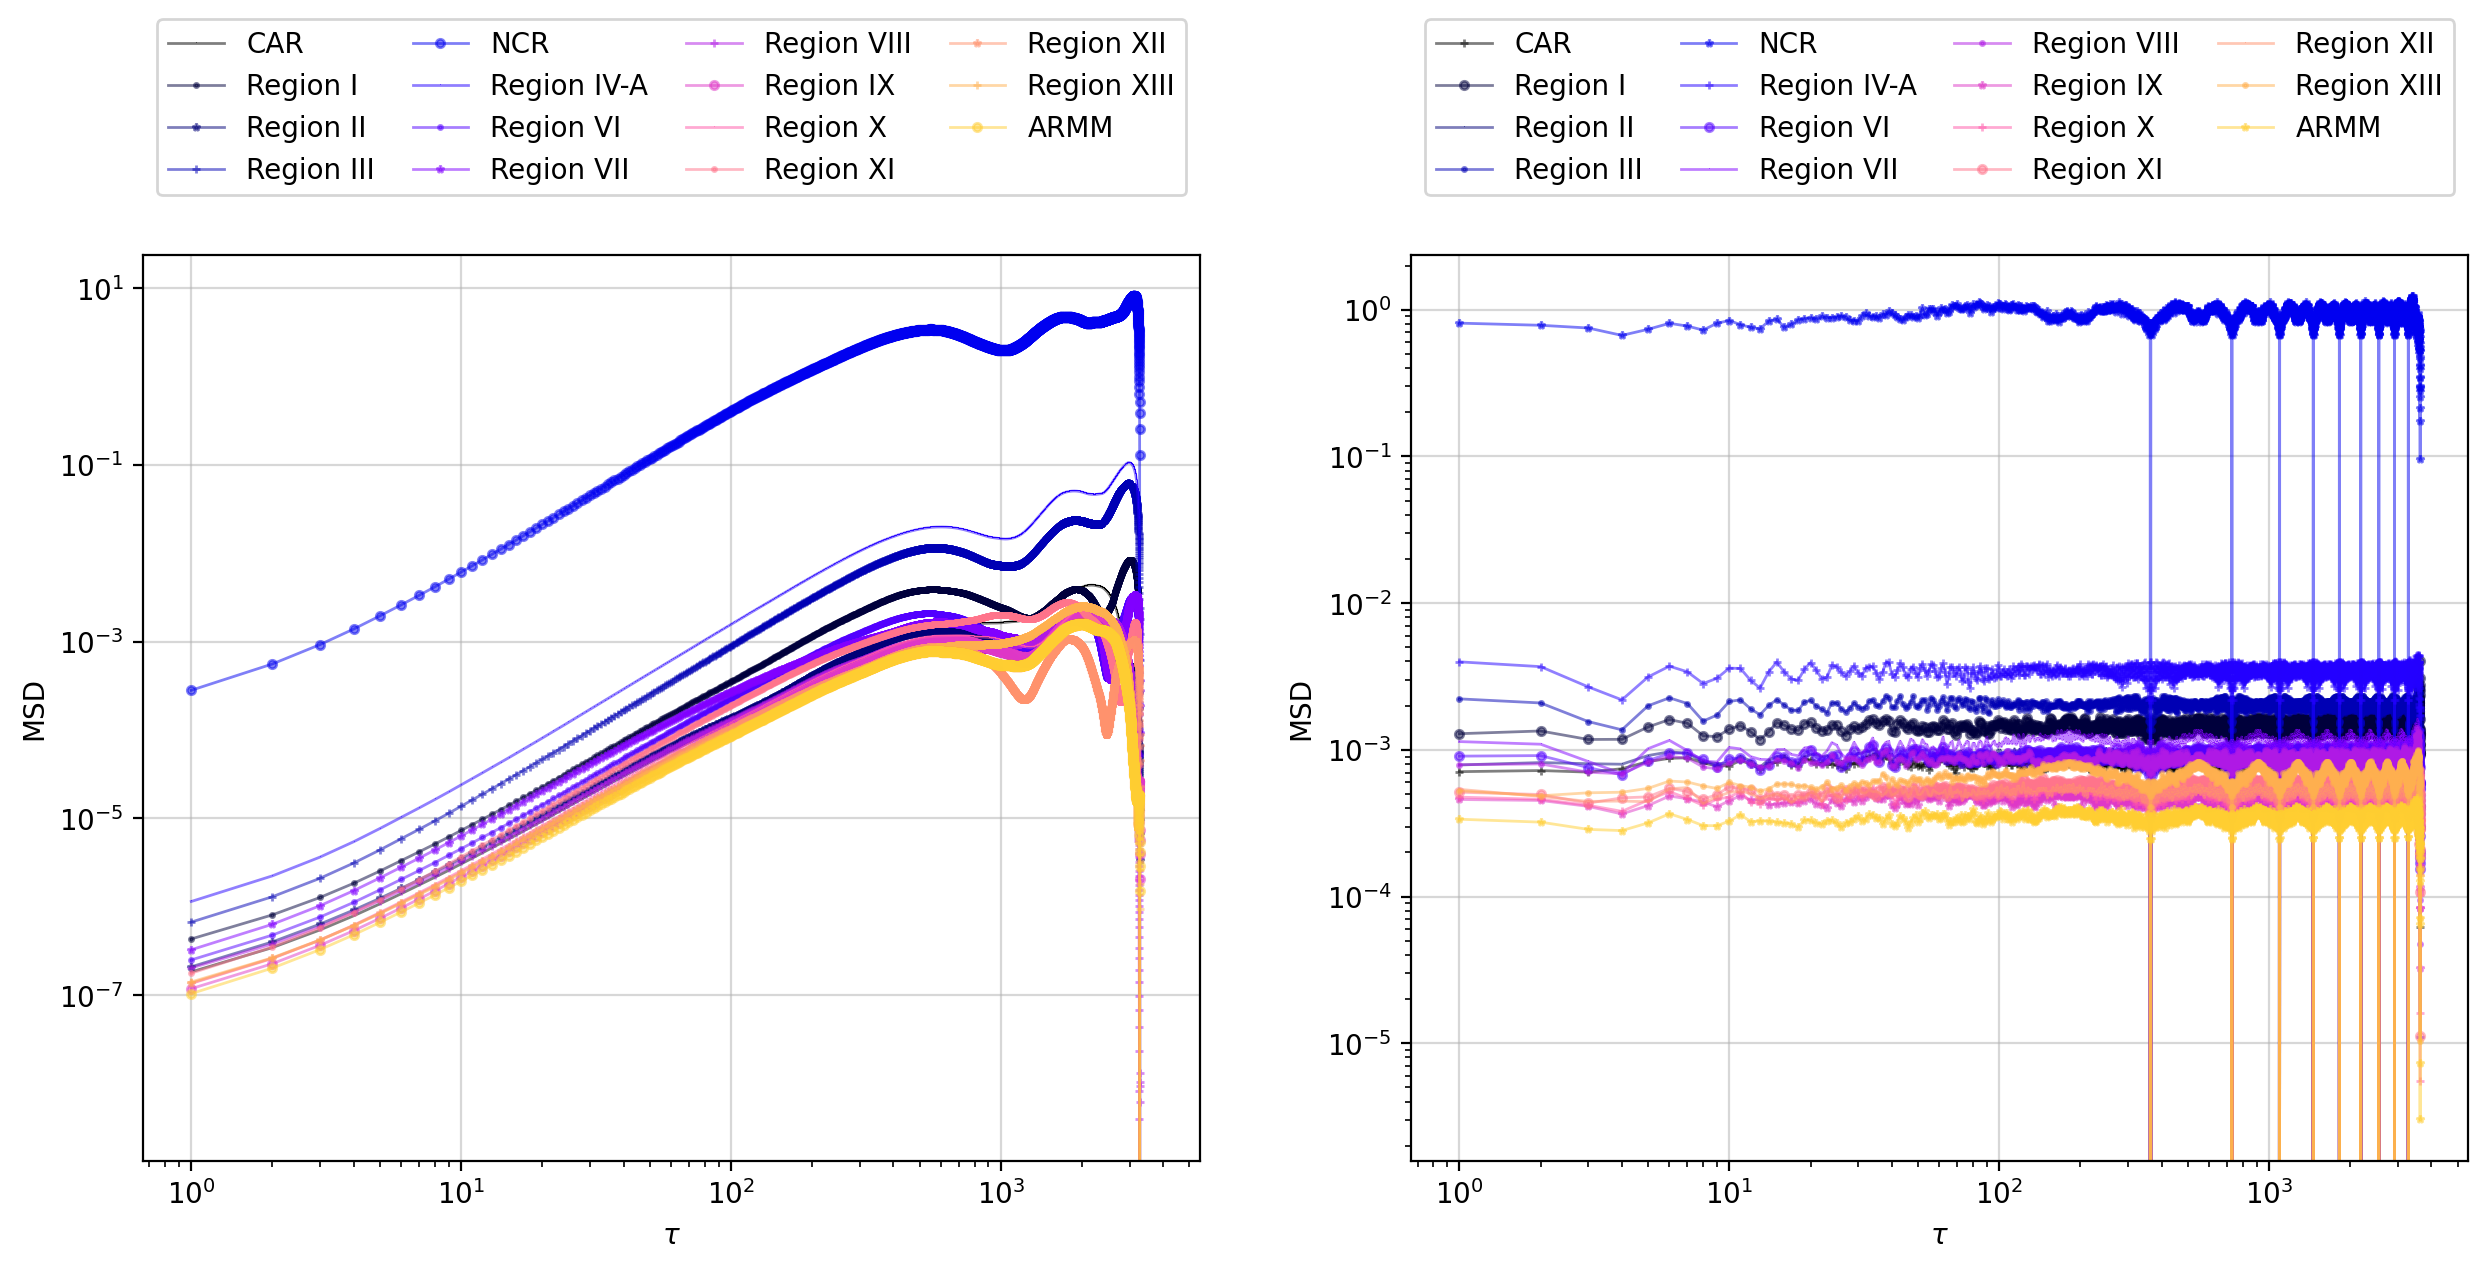

In [6]:
fig = plt.figure(dpi = 200, figsize = (15,6))
fig.patch.set_facecolor('None')

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting MSD'):
    plt.subplot(121)
    plt.plot(MSD_trend_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plot_in_log()
    plot_labels()
    
    plt.subplot(122)
    plt.plot(MSD_seasonality_df[loc], '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
    plot_in_log()
    plot_labels()

# MSD Fitting

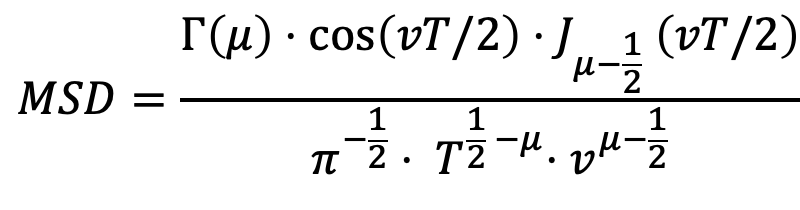

In [12]:
def msd_theo_ntl(T,v,mu,N):
    num = np.sqrt(np.pi)*gamma(mu)*np.cos((v*T)/2)*jv(mu-0.5,(v*T)/2)
    denom = T**(0.5-mu) * v**(mu-0.5)
    return N*num/denom

## Varying $\nu$ and $\mu$ parameters

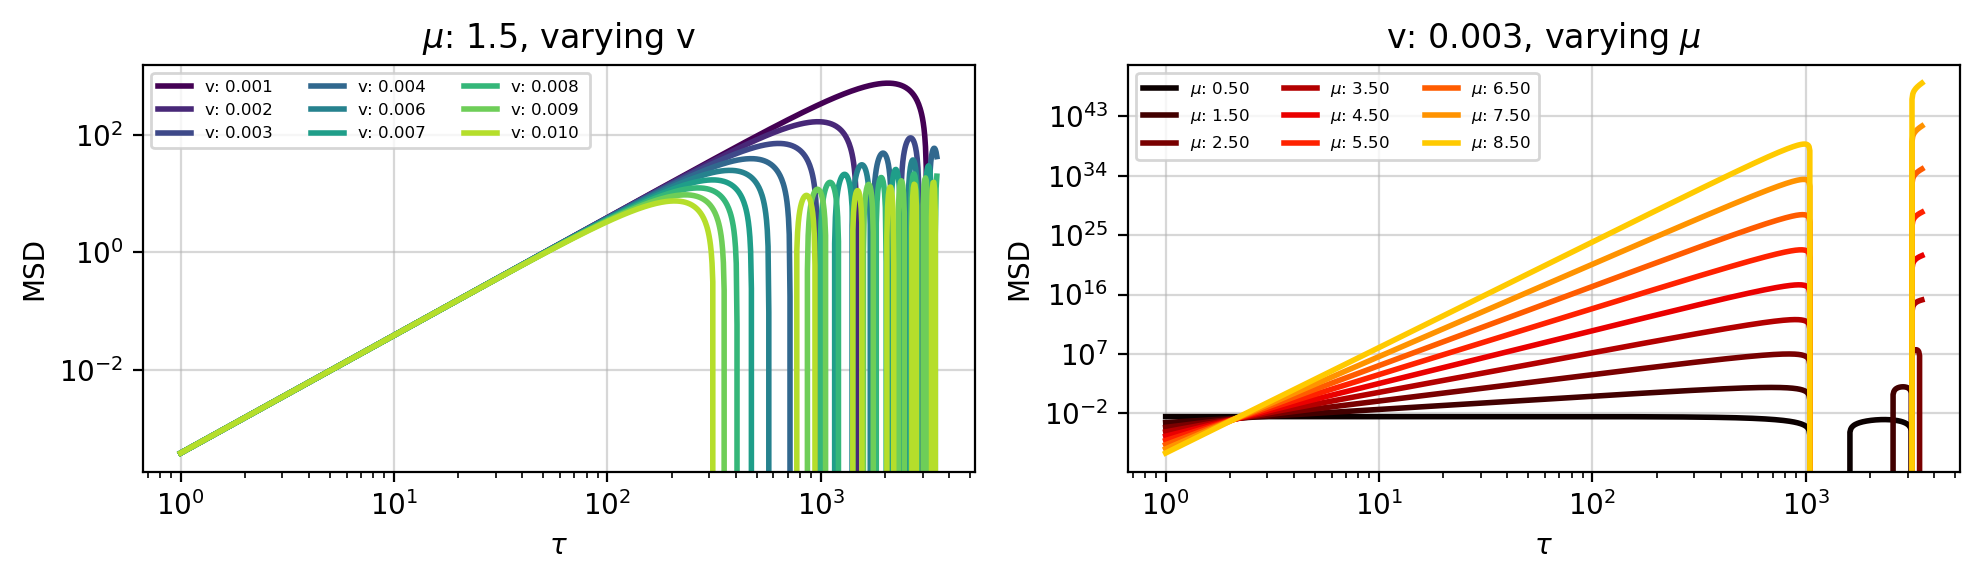

In [13]:
t = np.logspace(0, np.log10(3500), 1000)
v_vals = np.linspace(0.001,0.01,9)
mu_vals = np.linspace(0.5,8.5,9)
N = 1e-3

fig = plt.figure(dpi = 200, figsize = (10,3))
fig.patch.set_facecolor('None')

plt.subplot(121)
for i,v in enumerate(v_vals):
    mu = 1.5
    plt.plot(t, msd_theo_ntl(t,v,mu, N), '-', color = plt.cm.viridis((i)/9), lw = 2,
             label = r"v: %.3f " % (v))
    plt.title(r"$\mu$: %.1f, varying v" % (mu))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=6, ncol = 3, loc="upper left",
                bbox_transform=plt.gca().transAxes, fancybox = True)
    
plt.subplot(122)
for i,mu in enumerate(mu_vals):
    v = 0.003
    plt.plot(t, msd_theo_ntl(t,v,mu, N), '-', color = plt.cm.hot((i)/12), lw = 2,
             label = r"$\mu$: %.2f " % (mu))
    plt.title(r"v: %.3f, varying $\mu$" % (v))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=6, ncol = 3, loc="upper left",
                bbox_transform=plt.gca().transAxes, fancybox = True)
plt.tight_layout()
plt.show()

## NCR NTL Trends

In [14]:
empirical_MSDs = MSD_trend_df.dropna(how='all')
empirical_MSDs = empirical_MSDs[empirical_MSDs['NCR'] != 0]
tau_vals = np.asarray(empirical_MSDs.index)
emp_MSD = empirical_MSDs['NCR']

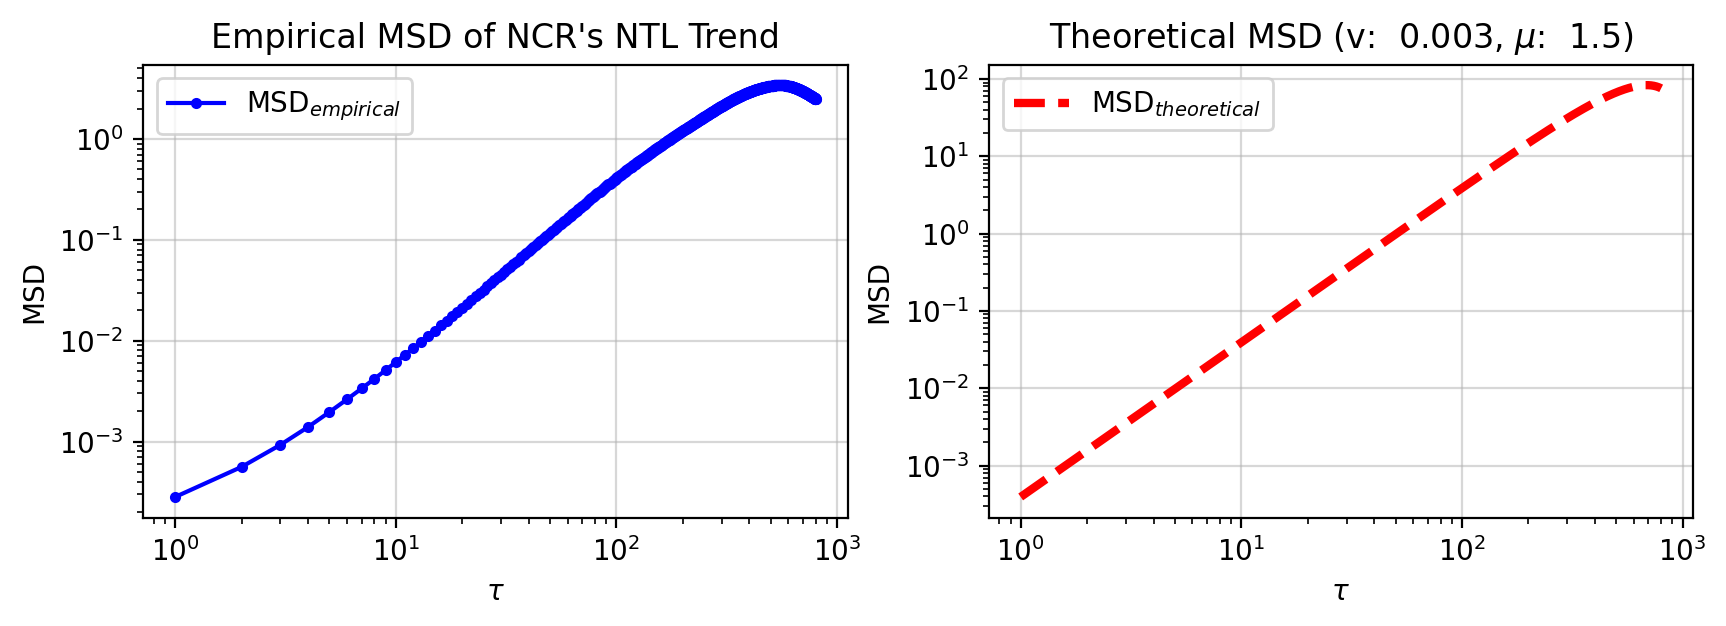

In [15]:
tau_0, tau_i = 0, 800
x_samp, y_samp = tau_vals[tau_0:tau_i], emp_MSD[tau_0:tau_i]

N = 1e-3
v = 0.003
mu = 1.5

plt.figure(figsize = (10,3), dpi = 200)
plt.subplot(121)
plt.plot(x_samp, y_samp, 'b.-', label="MSD$_{empirical}$")
plot_in_log()
plot_labels()
plt.legend()
plt.title('Empirical MSD of NCR\'s NTL Trend')

plt.subplot(122)
msd_theo = msd_theo_ntl(x_samp,v,mu,N)
plt.plot(x_samp, msd_theo, 'r--', label="MSD$_{theoretical}$", lw = 3)
plot_in_log()
plot_labels()
plt.legend()
plt.title('Theoretical MSD (v: % .3f, $\mu$: % .1f)' % (v, mu))

plt.show()

## Curve-fitting

In [16]:
initial_ss = [v, mu, N]

x_fit = tau_vals[tau_0:tau_i]
y_fit = emp_MSD[tau_0:tau_i]

popt, pcov = curve_fit(msd_theo_ntl, x_fit, y_fit, initial_ss, maxfev=5000)

fit_v, fit_mu, fit_N = popt[0], popt[1], popt[2]
err_v, err_mu, err_N = pcov[0,0]**0.5, pcov[1,1]**0.5, pcov[2,2]**0.5

print("v = %.5f (%.5f), mu = %.5f (%.5f), N = %.3e (%.3e)" % \
      (fit_v, err_v, fit_mu, err_mu, fit_N, err_N))

y_fit = msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N)

v = 0.00325 (0.00000), mu = 1.24910 (0.00242), N = 7.747e-04 (1.851e-05)


## Overlaying MSD Fit

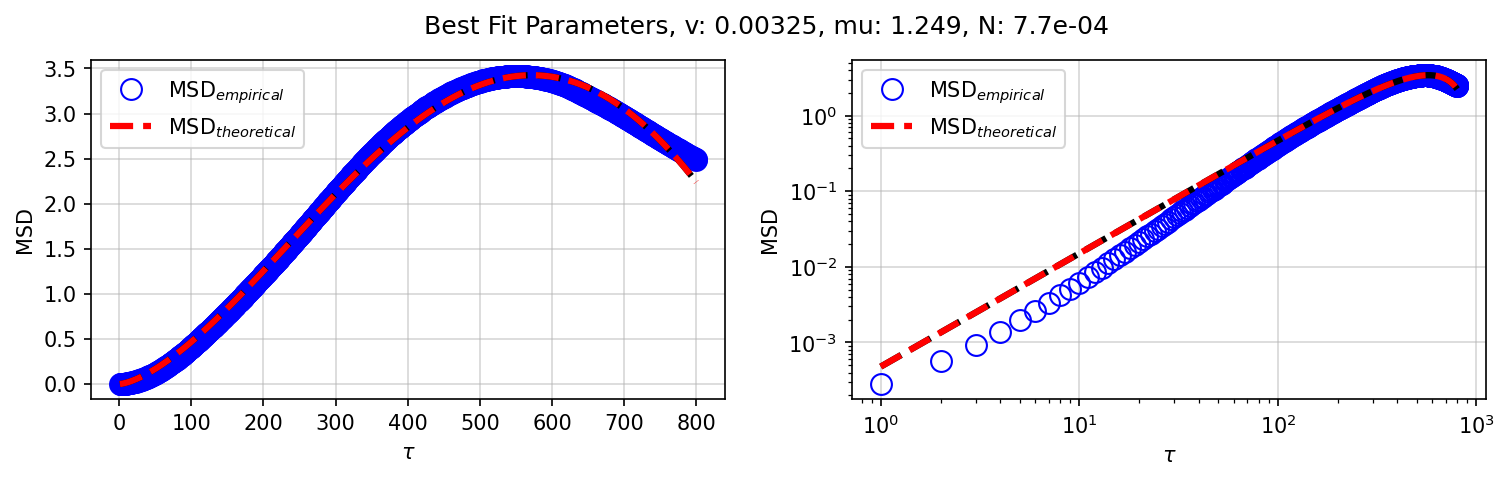

In [17]:
plt.figure(figsize = (12,3), dpi = 150)

plt.suptitle("Best Fit Parameters, v: %.5f, mu: %.3f, N: %.1e" % \
      (fit_v, fit_mu, fit_N))

plt.subplot(121)
plt.grid(alpha = 0.5)
plt.plot(x_samp, y_samp, 'bo', ms= 10, mfc='none', label="MSD$_{empirical}$")
plt.plot(x_samp, y_fit, 'k--', lw = 3.01)
plt.plot(x_samp, y_fit, 'r--', lw = 3, label = "MSD$_{theoretical}$")
plot_labels()
plt.legend()

plt.subplot(122)
plt.plot(x_samp, y_samp, 'bo', ms=10, mfc='none', label="MSD$_{empirical}$")
plt.plot(x_samp, y_fit, 'k--', lw = 3.05)
plt.plot(x_samp, y_fit, 'r--', lw = 3, label = "MSD$_{theoretical}$")
plot_in_log()
plot_labels()
plt.legend()

plt.show()

## MSD parameters

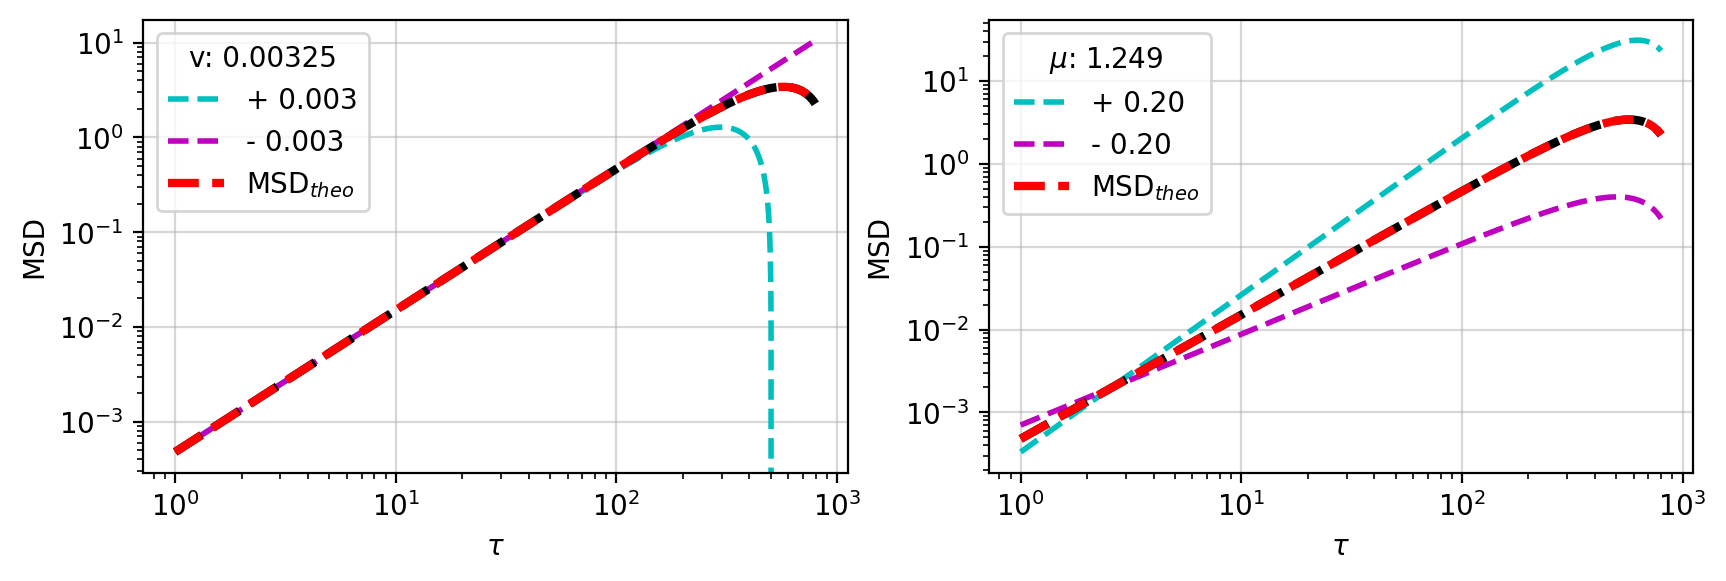

In [18]:
fig = plt.figure(dpi = 200, figsize = (10,3))
fig.patch.set_facecolor('None')

v_shift = 0.003
mu_shift = 0.2

plt.subplot(121)
# plt.plot(x_samp, y_samp, 'b-', alpha=0.5, lw=1, label="empirical MSD"
plt.plot(x_samp, msd_theo_ntl(x_samp, fit_v+v_shift, fit_mu, fit_N), 'c--', lw = 2, \
         label = "+ %.3f" % (v_shift))
plt.plot(x_samp, msd_theo_ntl(x_samp,fit_v-v_shift, fit_mu, fit_N), 'm--', lw = 2, \
         label = "- %.3f" % (v_shift))
plt.plot(x_samp, y_fit, 'k--', lw = 3.05)
plt.plot(x_samp, msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N), 'r--', lw = 3, label = "MSD$_{theo}$")
plot_in_log()
plot_labels()
plt.legend(title = "v: %.5f" % (fit_v))

plt.subplot(122)
# plt.plot(x_samp, y_samp, 'b-', alpha=0.5, lw=1, label="empirical MSD")
plt.plot(x_samp, msd_theo_ntl(x_samp, fit_v, fit_mu+mu_shift, fit_N), 'c--', lw = 2, 
         label = "+ %.2f" % (mu_shift))
plt.plot(x_samp, msd_theo_ntl(x_samp, fit_v, fit_mu-mu_shift, fit_N), 'm--', lw = 2, 
         label = "- %.2f" % (mu_shift))
plt.plot(x_samp, y_fit, 'k--', lw = 3.05)
plt.plot(x_samp, msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N), 'r--', lw = 3, label = "MSD$_{theo}$")
plt.legend(title = "$\mu$: %.3f" % (fit_mu))
plot_in_log()
plot_labels()

## Regional MSD fits

In [19]:
MSD_params = pd.DataFrame([], index = regions, 
                          columns = ['fit_v', 'err_v', 'fit_mu', 'err_mu', 'fit_N', 'err_N'])

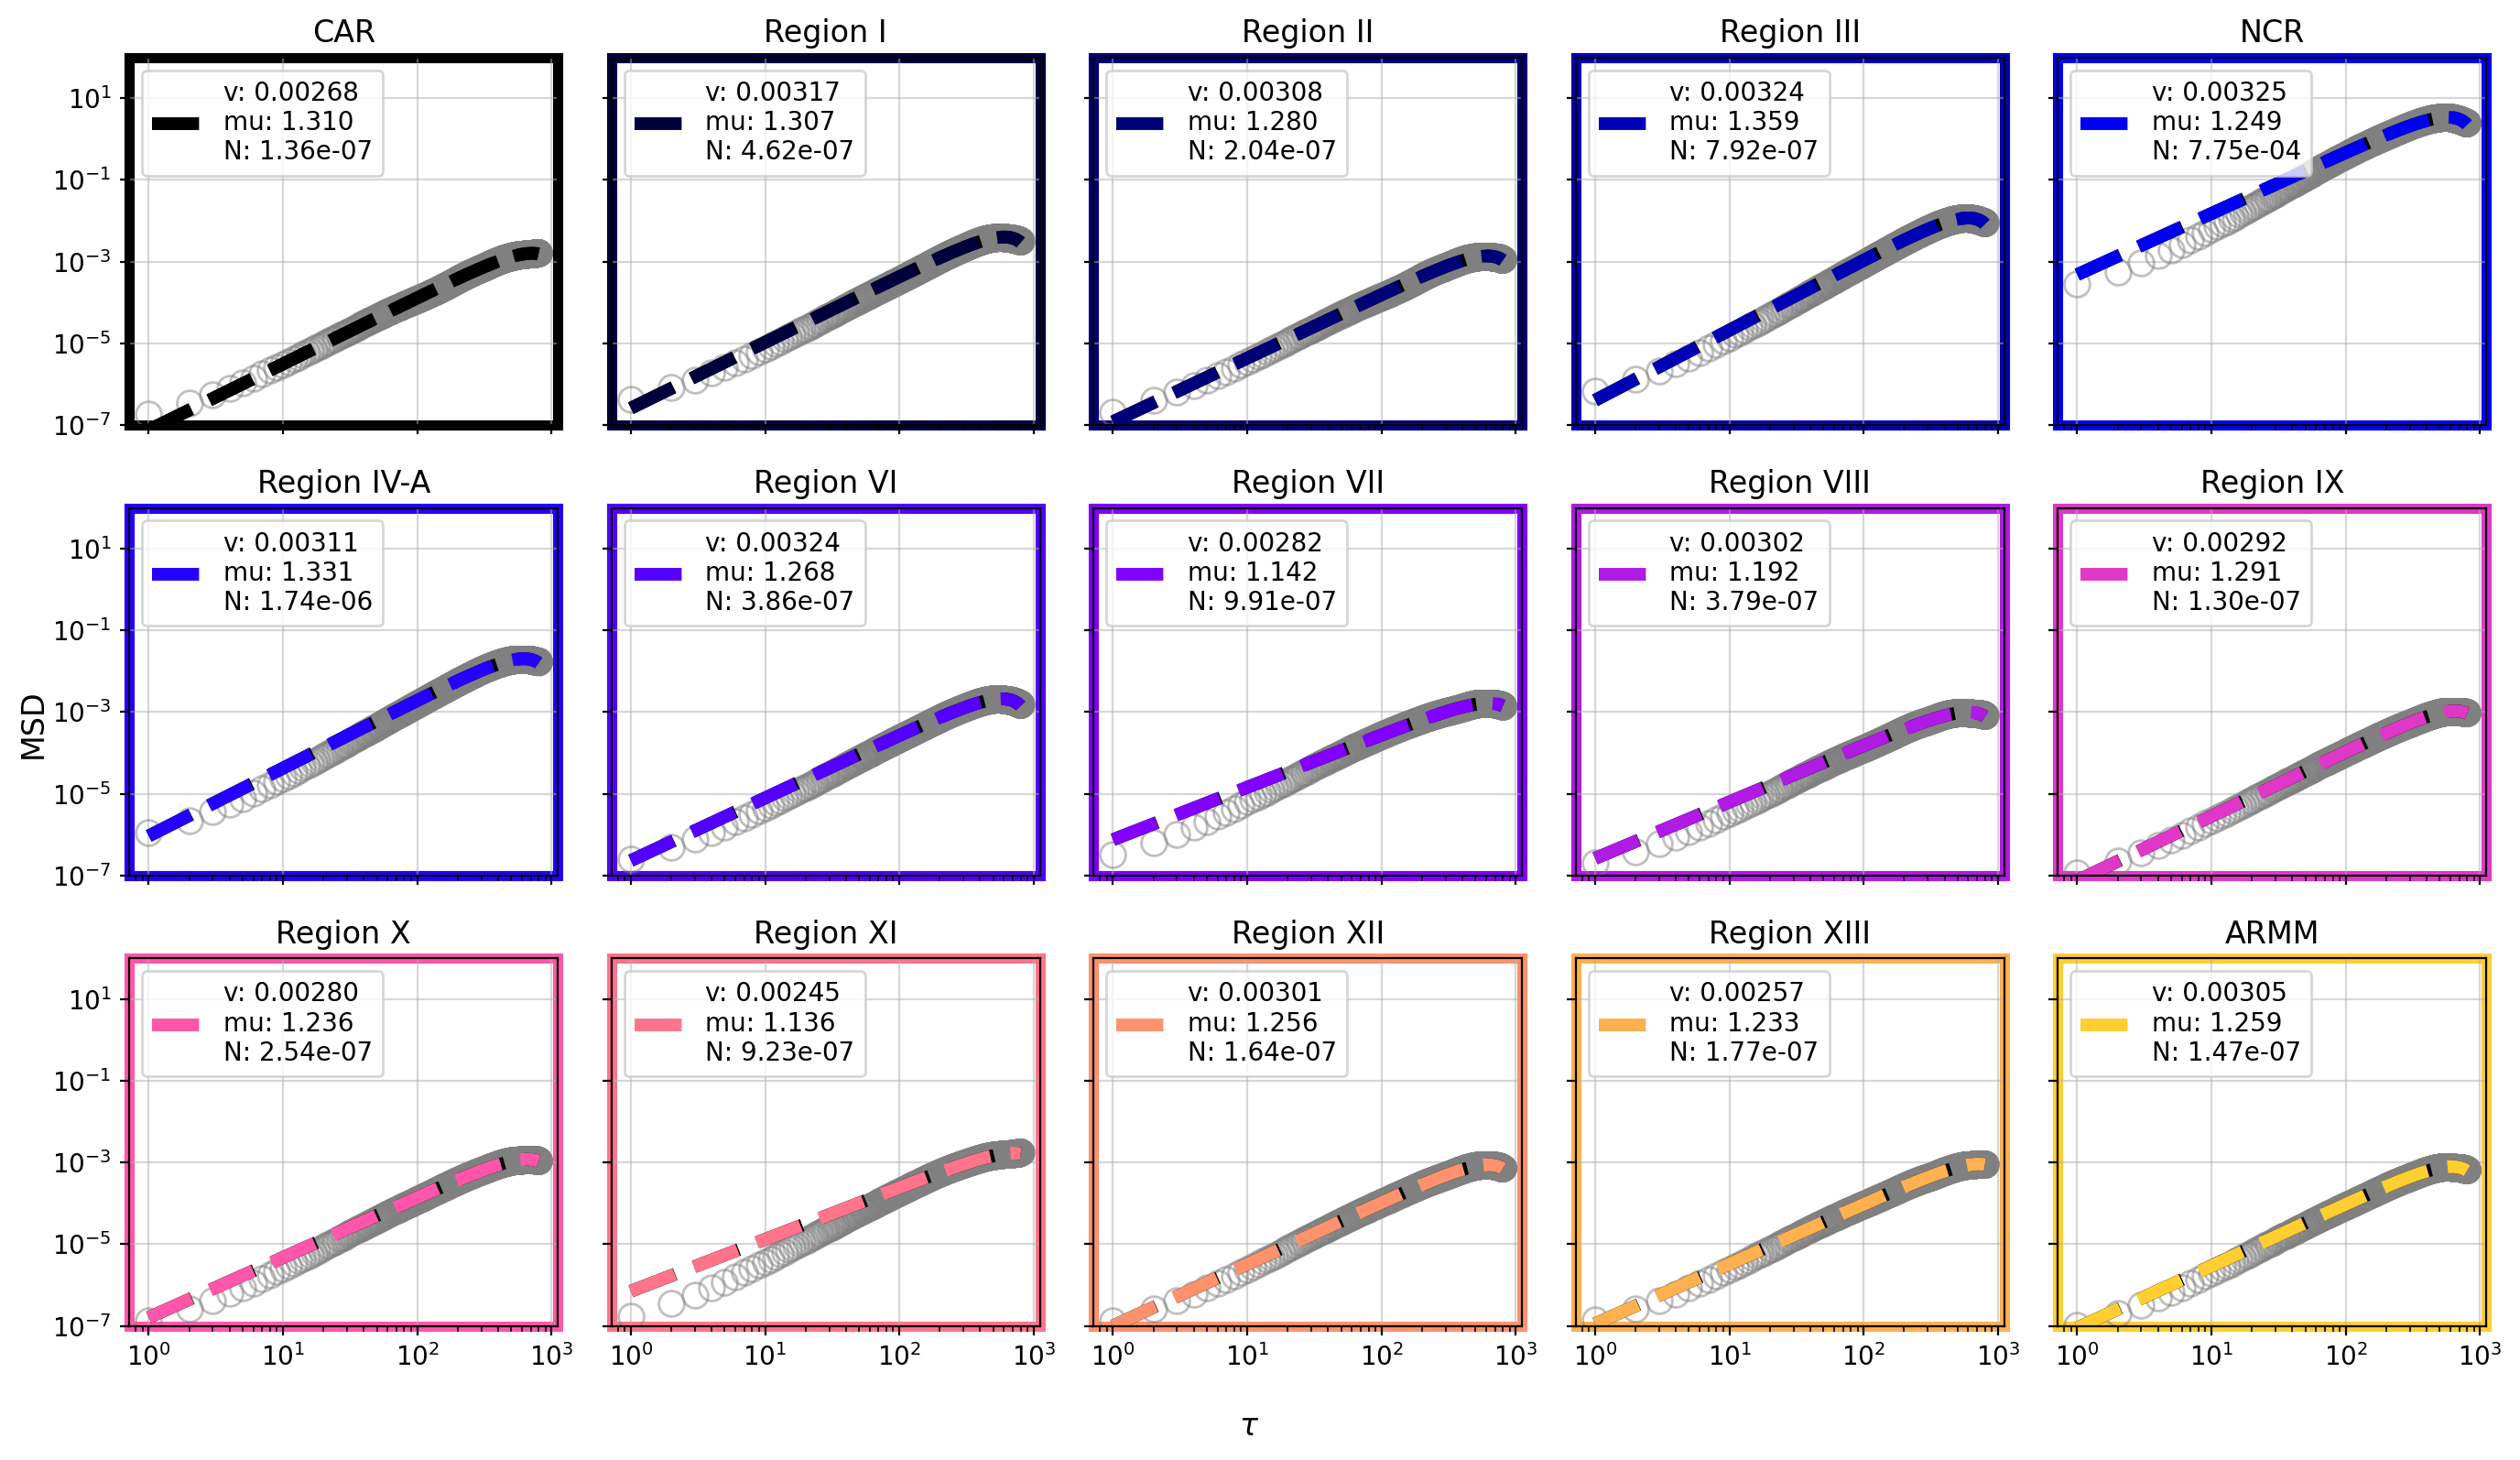

In [20]:
fig, axes = plt.subplots(nrows=3,ncols=5, sharex='col', sharey='row',
                         figsize = (14,8), dpi = 200)

for i, ax in enumerate(axes.ravel()):
    
    region = regions[i]

    emp_MSD = empirical_MSDs[region].values

    v, mu, N = 0.003, 1.5, 1e-3
    initial_ss = [v, mu, N]

    tau_0, tau_i = 0, 800
    x_samp, y_samp = tau_vals[tau_0:tau_i], emp_MSD[tau_0:tau_i]

    popt, pcov = curve_fit(msd_theo_ntl, x_samp, y_samp, initial_ss, maxfev=5000)
    fit_v, fit_mu, fit_N = popt[0], popt[1], popt[2]
    err_v, err_mu, _N = pcov[0,0]**0.5, pcov[1,1]**0.5, pcov[2,2]**0.5
    
    MSD_params.loc[region] = fit_v, err_v, fit_mu, err_mu, fit_N, err_N

    y_fit = msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N)

    ax.set_title(str(region), fontsize = 12)
    ax.grid(alpha = 0.5)
    ax.plot(x_samp, y_samp, 'o', color = 'gray', ms=10, mfc='none', alpha = 0.5)
    ax.plot(x_samp, y_fit, 'k--', lw = 5.05)
    ax.plot(x_samp, y_fit, '--', lw = 5, label = "v: %.5f \nmu: %.3f \nN: %.2e" % (fit_v, fit_mu, fit_N),
           color = plt.cm.gnuplot2(i/17))
    ax.legend(loc = 'upper left')
    ax.set_ylim(1e-7,1e2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.patch.set(lw=4, ec=plt.cm.gnuplot2(i/17))
    
fig.supxlabel(r'$\tau$')
fig.supylabel('MSD')
plt.tight_layout()
plt.show()

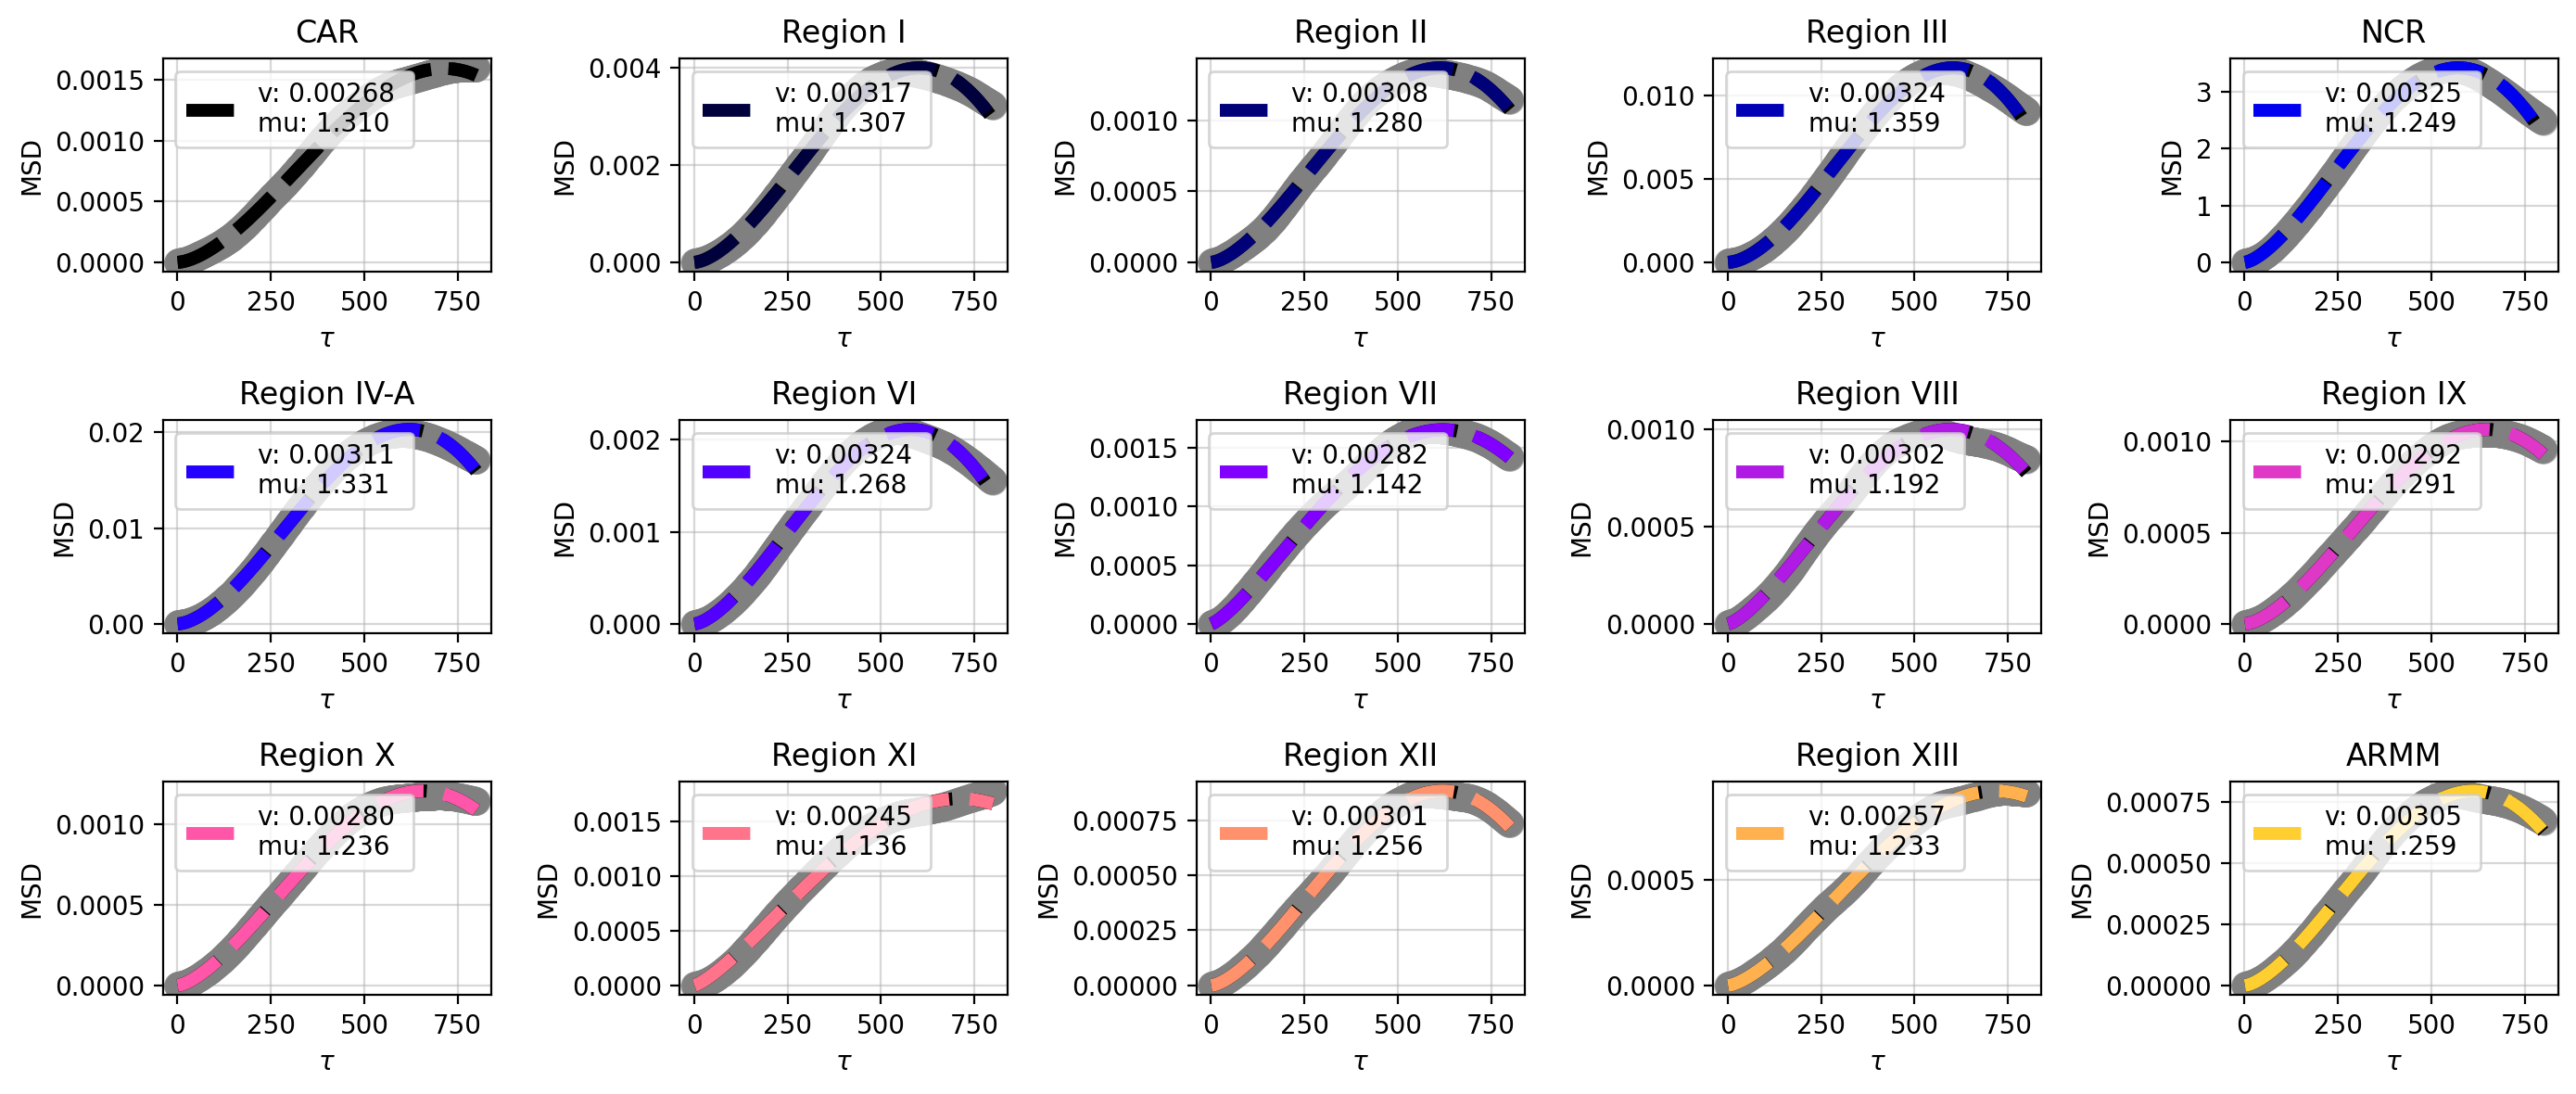

In [22]:
fig, axes = plt.subplots(nrows=3,ncols=5,
                         figsize = (14,6), dpi = 200)

for i, ax in enumerate(axes.ravel()):
    
    region = regions[i]

    emp_MSD = empirical_MSDs[region].values

    v, mu, N = 0.003, 1.5, 1e-3
    initial_ss = [v, mu, N]

    tau_0, tau_i = 0, 800
    x_samp, y_samp = tau_vals[tau_0:tau_i], emp_MSD[tau_0:tau_i]

    popt, pcov = curve_fit(msd_theo_ntl, x_samp, y_samp, initial_ss, maxfev=5000)
    fit_v, fit_mu, fit_N = popt[0], popt[1], popt[2]
    err_v, err_mu, _N = pcov[0,0]**0.5, pcov[1,1]**0.5, pcov[2,2]**0.5
    
    MSD_params.loc[region] = fit_v, err_v, fit_mu, err_mu, fit_N, err_N

    y_fit = msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N)

    ax.set_title(str(region))
    ax.grid(alpha = 0.5)
    ax.plot(x_samp, y_samp, 'o', color = 'gray', ms=10, mfc='none', alpha = 0.5)
    ax.plot(x_samp, y_fit, 'k--', lw = 5.05)
    ax.plot(x_samp, y_fit, '--', lw = 5, label = "v: %.5f \nmu: %.3f" % (fit_v, fit_mu),
           color = plt.cm.gnuplot2(i/17))
    ax.legend(loc = 'upper left')
#     ax.set_ylim(1e-7,1e2)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('MSD')
plt.tight_layout()
plt.show()

In [23]:
MSD_params = MSD_params.apply(pd.to_numeric, errors='coerce')
MSD_params

# # from matplotlib.colors import LogNorm
# plt.figure(figsize=(12, 8), dpi = 200)
# sns.heatmap(MSD_params, annot=True, fmt='g', cmap='RdYlBu_r', linewidths=.5)
# plt.xlabel('$\Delta_{NTL}$, $nW·cm^{−2}·sr^{−1}$')
# plt.show()

fit_v     err_v    fit_mu    err_mu         fit_N     err_N
CAR          0.002683  0.000008  1.310327  0.002823  1.355416e-07  0.000019
Region I     0.003170  0.000007  1.306779  0.003483  4.619204e-07  0.000019
Region II    0.003075  0.000006  1.279555  0.002631  2.040720e-07  0.000019
Region III   0.003243  0.000005  1.358673  0.002837  7.917895e-07  0.000019
NCR          0.003247  0.000005  1.249103  0.002423  7.747107e-04  0.000019
Region IV-A  0.003111  0.000005  1.330918  0.002673  1.742609e-06  0.000019
Region VI    0.003236  0.000006  1.268100  0.002777  3.860527e-07  0.000019
Region VII   0.002815  0.000004  1.142082  0.001454  9.911669e-07  0.000019
Region VIII  0.003018  0.000008  1.192075  0.003260  3.790107e-07  0.000019
Region IX    0.002925  0.000003  1.290832  0.001409  1.295563e-07  0.000019
Region X     0.002804  0.000007  1.235959  0.002600  2.535138e-07  0.000019
Region XI    0.002451  0.000014  1.135606  0.003759  9.233768e-07  0.000019
Region XII   0.003006  0.000004  1.256477  0.001523  1.637680e-07  0.000019
Region XIII  0.002567  0.000005  1.232852  0.001596  1.766660e-07  0.000019
ARMM         0.003046  0.000006  1.258675  0.002705  1.471249e-07  0.000019

## Best-fit Parameters

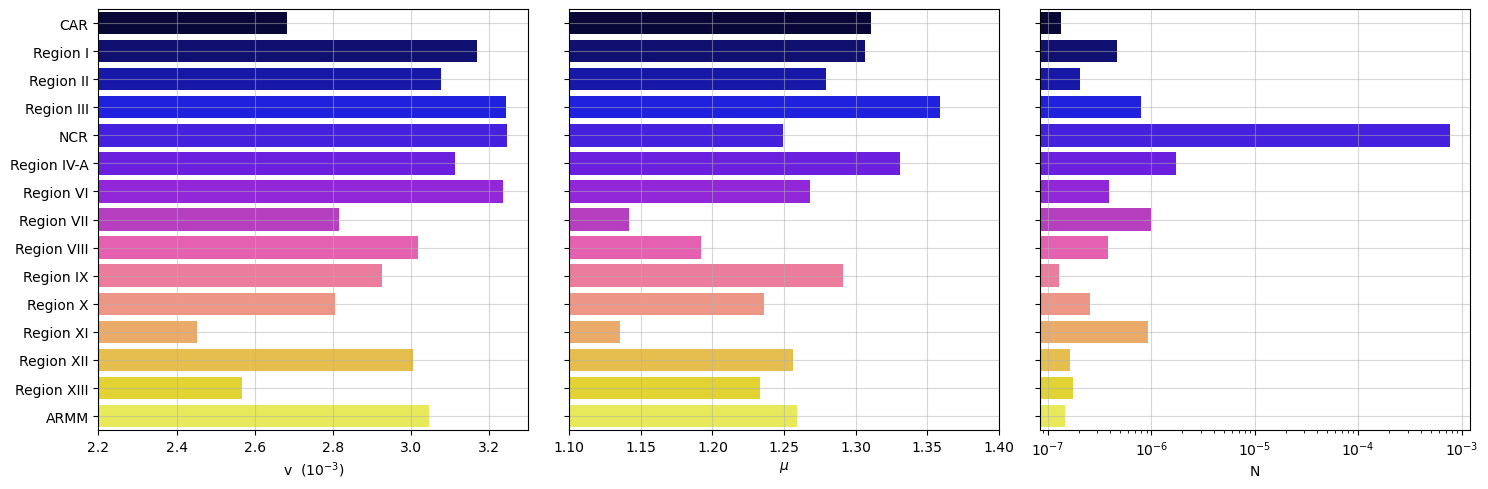

In [24]:
fig, ax = plt.subplots(ncols = 3, nrows = 1, sharey=True,
                       figsize = (15,5), dpi = 100)

palette = sns.color_palette('gnuplot2', n_colors=len(MSD_params))


sns.barplot(x='fit_v', y=MSD_params.index, data=MSD_params*1000,
            palette=palette, ax = ax[0])
ax[0].set_xlabel('v  ($10^{-3}$)')
ax[0].set_xlim(2.2, 3.3)



sns.barplot(x='fit_mu', y=MSD_params.index, data=MSD_params, palette=palette,
           ax = ax[1])
ax[1].set_xlabel('$\mu$')
ax[1].set_xlim(1.1,1.4)


sns.barplot(x='fit_N', y=MSD_params.index, data=MSD_params, palette=palette,
           ax = ax[2])
ax[2].set_xlabel('N')
ax[2].set_xscale('log')

for ax in ax: 
    ax.grid(alpha = 0.5)
plt.tight_layout()

#     ax.set_xscale('log')

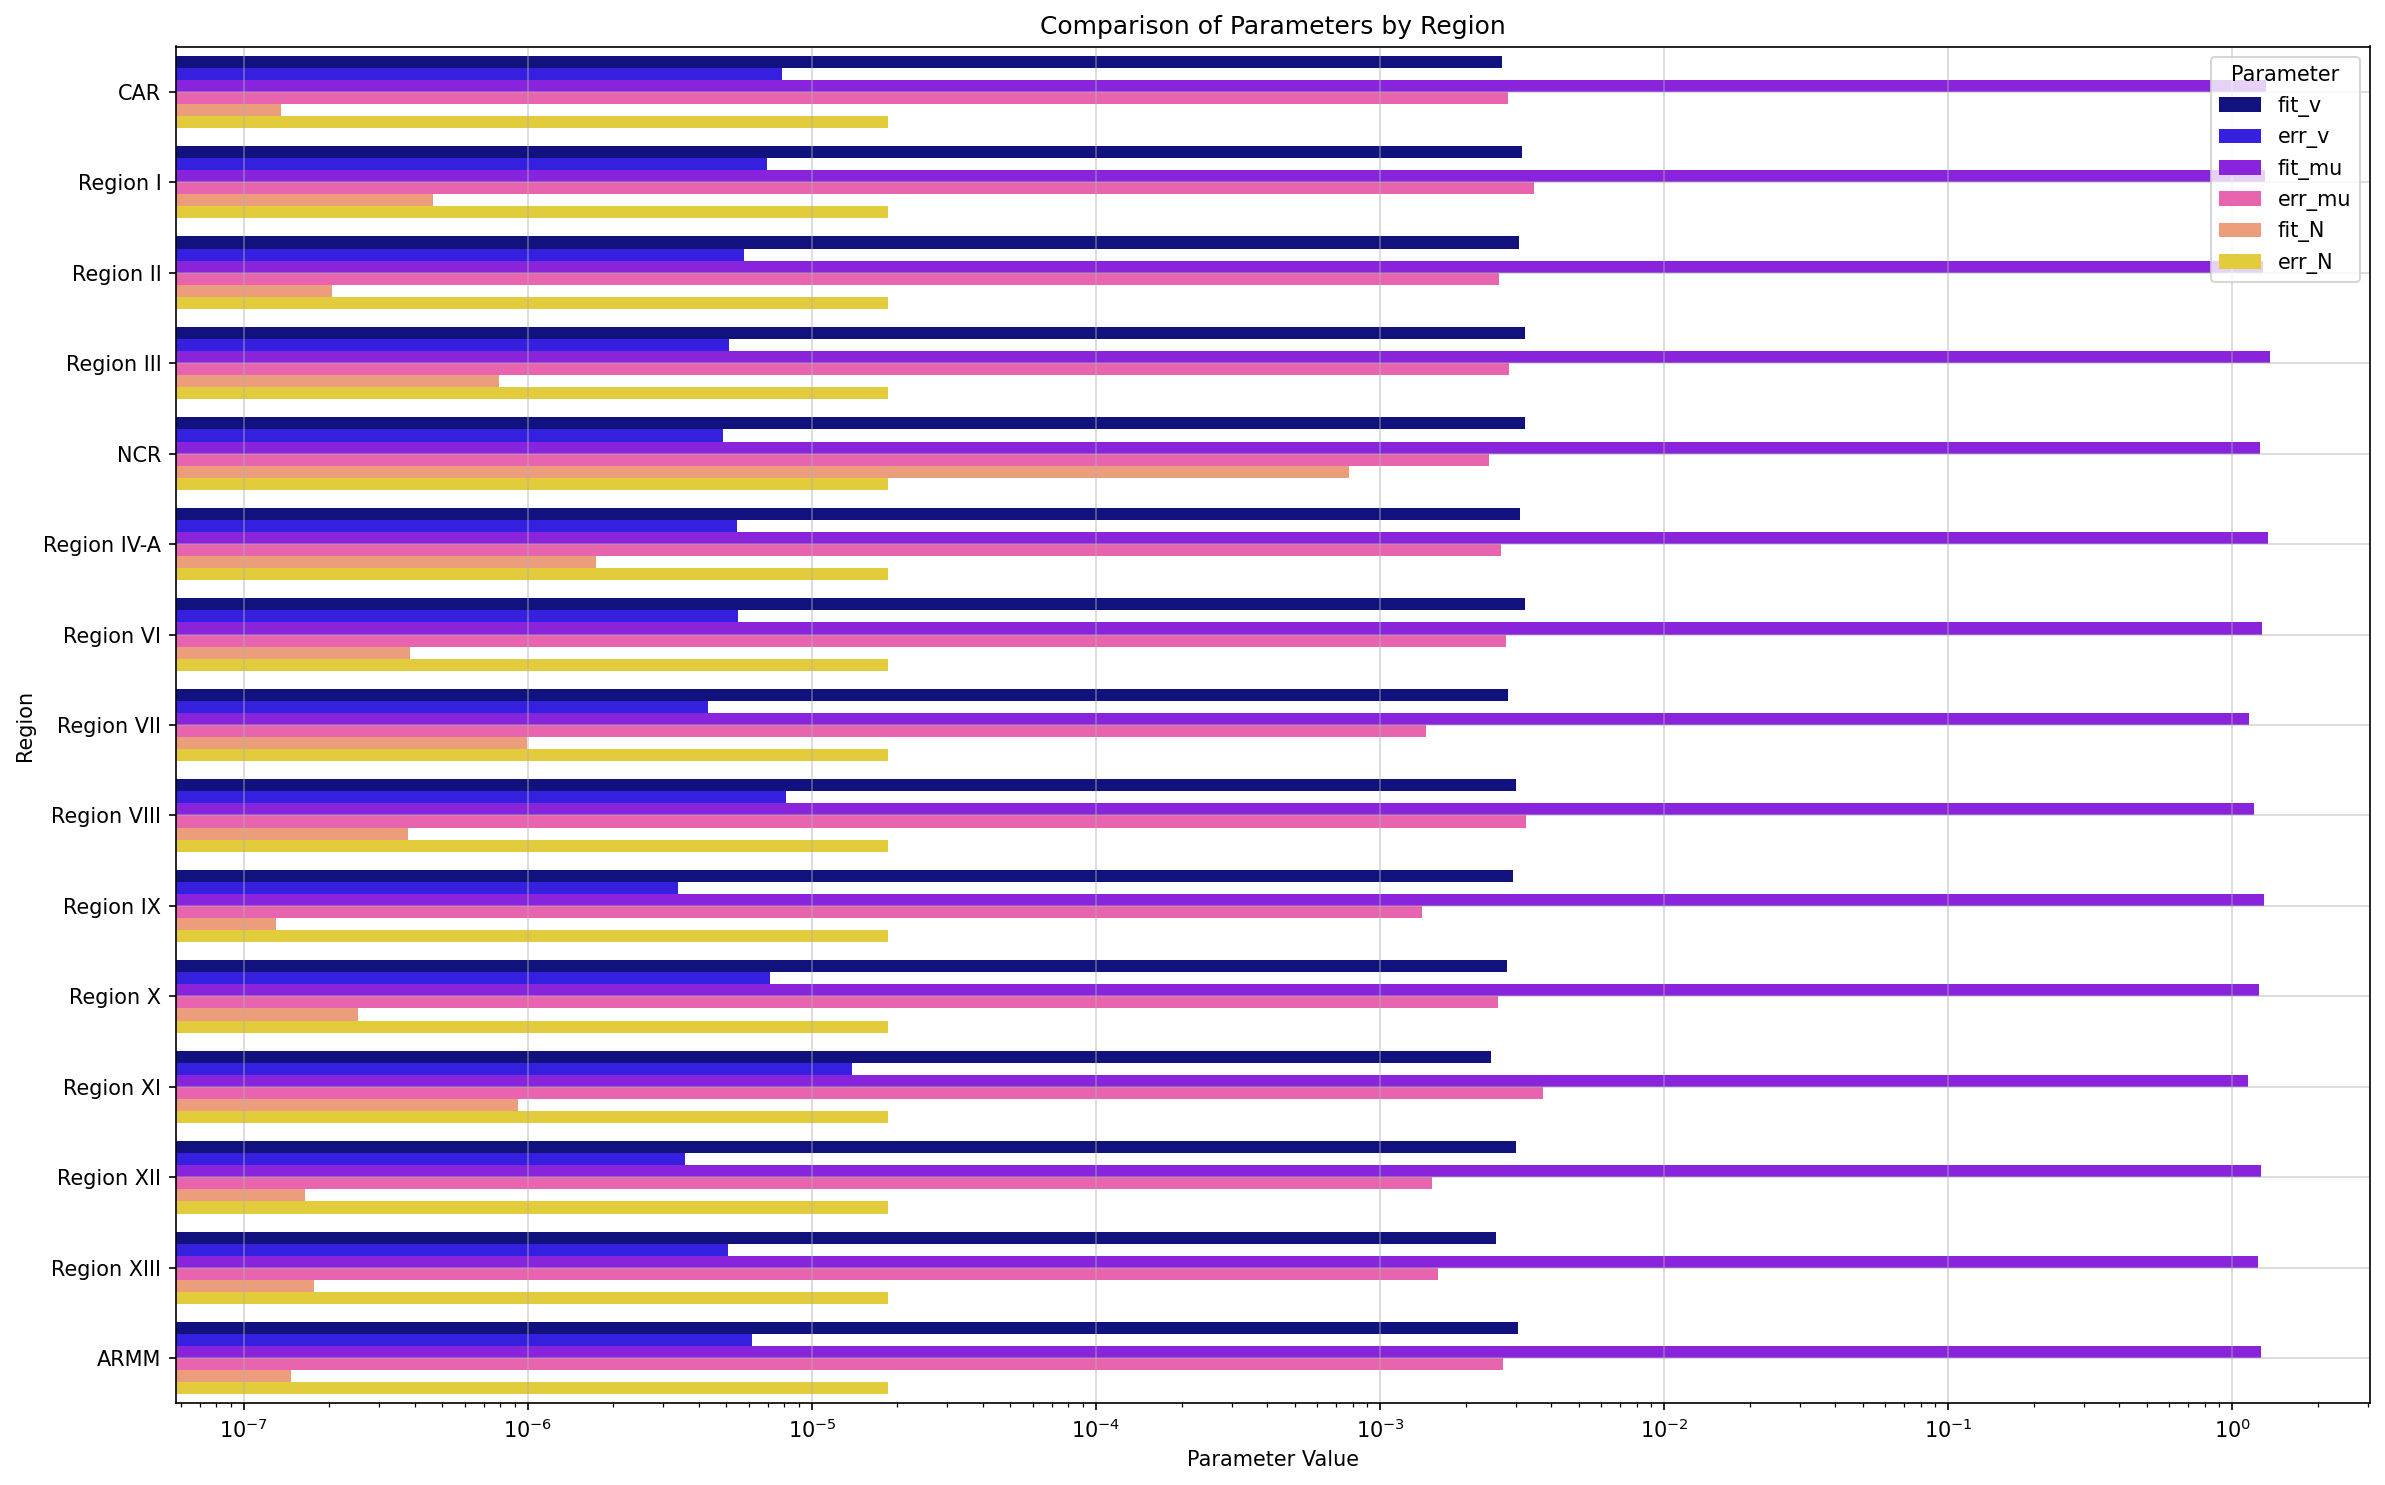

In [25]:
# Convert the index to a column
MSD_params_reset = MSD_params.reset_index()

# Melt the DataFrame to combine 'fit_v', 'fit_mu', 'fit_N' into a single column
msd_params_melted = MSD_params_reset.melt(id_vars='index', var_name='Parameter', value_name='Value')

# Create a grouped bar plot
plt.figure(figsize=(16, 10), dpi = 150)

sns.barplot(x='Value', y=msd_params_melted['index'], hue='Parameter', data=msd_params_melted, palette='gnuplot2')

plt.xlabel('Parameter Value')
plt.ylabel('Region')
plt.title('Comparison of Parameters by Region')
plt.xscale('log')
plt.legend(title='Parameter')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# First Passage Time Density

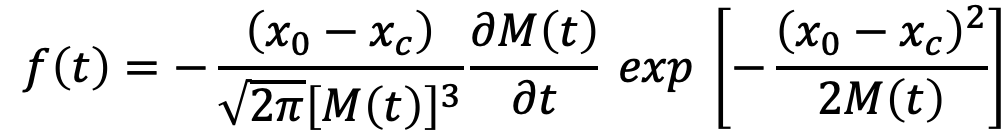

In [26]:
empirical_MSDs = MSD_trend_df.dropna(how='all')
empirical_MSDs = empirical_MSDs[empirical_MSDs['NCR'] != 0]
tau_vals = np.asarray(empirical_MSDs.index)
emp_MSD = empirical_MSDs['NCR']

tau_0, tau_i = 0, 800
x_samp, y_samp = tau_vals[tau_0:tau_i], emp_MSD[tau_0:tau_i]

N = 1e-3
v = 0.003
mu = 1.5

initial_ss = [v, mu, N]

x_fit = tau_vals[tau_0:tau_i]
y_fit = emp_MSD[tau_0:tau_i]

popt, pcov = curve_fit(msd_theo_ntl, x_fit, y_fit, initial_ss, maxfev=5000)

fit_v, fit_mu, fit_N = popt[0], popt[1], popt[2]
err_v, err_mu, err_N = pcov[0,0]**0.5, pcov[1,1]**0.5, pcov[2,2]**0.5

print("v = %.5f (%.5f), mu = %.5f (%.5f), N = %.3e (%.3e)" % \
      (fit_v, err_v, fit_mu, err_mu, fit_N, err_N))

y_fit = msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N)

v = 0.00325 (0.00000), mu = 1.24910 (0.00242), N = 7.747e-04 (1.851e-05)


In [27]:
def partial_MSD(T,v,mu,N):
    term1 = (np.sqrt(np.pi) * gamma(mu) * np.power(v, 3/2 - mu)) / 2
    term2 = np.power(T, mu - 1/2)
    term3 = (np.cos(v*T/2)*jv(mu-3/2, v*T/2)) - (np.sin(v*T/2)*jv(mu-1/2, v*T/2))
    return term1*term2*term3

In [28]:
MSD_theo = msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N)
par_MSD_theo = partial_MSD(x_samp, fit_v, fit_mu, fit_N)

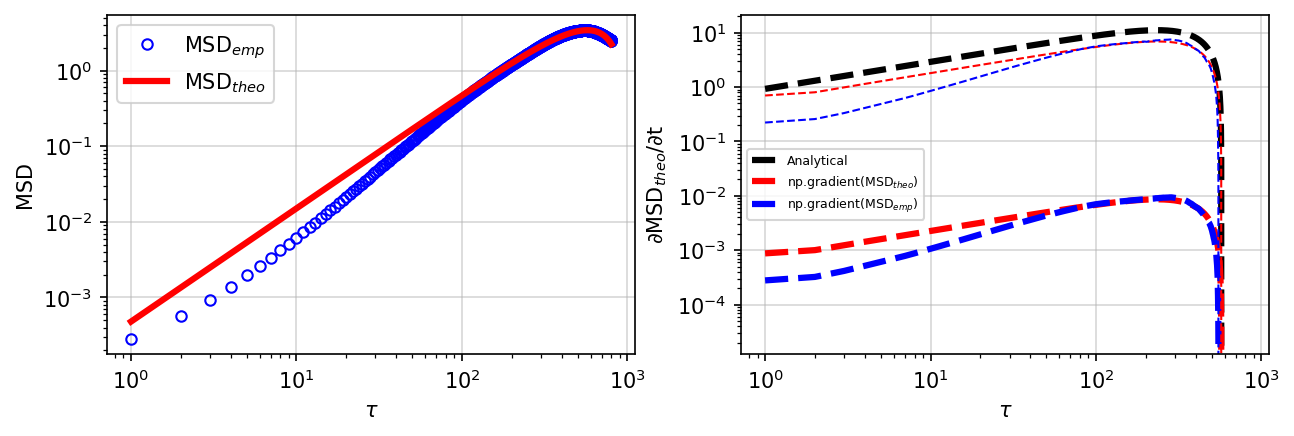

In [29]:
plt.figure(figsize = (10,3), dpi = 150)

plt.subplot(121)
plt.grid(alpha = 0.5)
plt.plot(x_samp, y_samp, 'bo', ms=5, mfc='none', label="MSD$_{emp}$")
plt.plot(x_samp, MSD_theo, 'r-', lw = 3, label = "MSD$_{theo}$")
plot_in_log()
plot_labels()
plt.legend()

plt.subplot(122)
plt.plot(x_samp, par_MSD_theo, 'k--', lw = 3, label = 'Analytical') #label = "$\partial$MSD$_{theo}$/$\partial$t")
plt.plot(x_samp, np.gradient(MSD_theo), 'r--', lw = 3, label = "np.gradient(MSD$_{theo}$)")
plt.plot(x_samp, np.gradient(y_samp), 'b--', lw = 3, label = "np.gradient(MSD$_{emp}$)")

plt.plot(x_samp, 800*np.gradient(MSD_theo), 'r--', lw = 1)
plt.plot(x_samp, 800*np.gradient(y_samp), 'b--', lw = 1)
plot_in_log()
plot_labels()
plt.legend(fontsize = 6)
plt.ylabel('$\partial$MSD$_{theo}$/$\partial$t')
plt.show()

## Using Analytical MSD$_{theo}$

In [30]:
def fptd(dx, T,v, mu, N):
    term1_num = gamma(mu) * np.power(T, (1/2 - mu)/2) * np.power(v, (mu + 3/2)/2) * dx
    term1_denom = np.power(np.sqrt(np.pi) * gamma(mu) * np.cos(v*T/2) * jv(mu - 1/2, v*T/2), 3/2)
    
    term2_num = np.power(T, (1/2 - mu)) * np.power(v, (mu-1/2)) * np.power(dx,2)
    term2_denom = 2*np.sqrt(np.pi) * gamma(mu) * np.cos(v*T/2) * jv(mu-1/2, v*T/2)
    
    term1 = term1_num/term1_denom
    term2 = np.exp(-term1_num/term1_denom)
    term3 = (np.cos(v*T/2)*jv(mu-3/2, v*T/2)) - (np.sin(v*T/2)*jv(mu-1/2, v*T/2))
    return term1*term2*term3

## Using Numerical MSD$_{theo}$

In [31]:
def fptd_(dx, m, v, mu, N):
    term_1 = np.abs(dx)/(np.sqrt(2 * np.pi)* m**3) 
    MSD_prime = np.gradient(m)
    term_3 = np.exp(-(dx**2)/(2 * m))
    f_t = term_1*MSD_prime*term_3
    return f_t

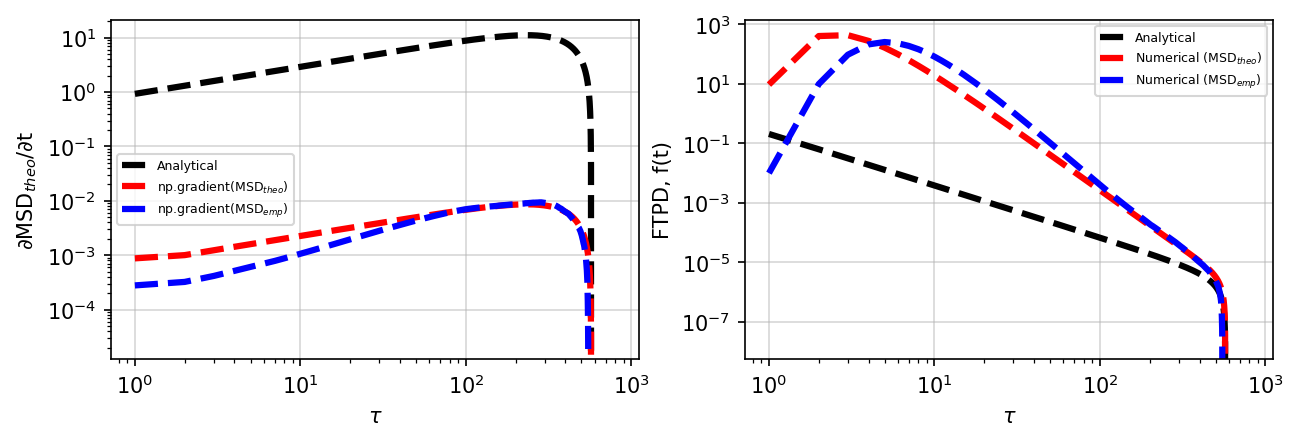

In [32]:
plt.figure(figsize = (10,3), dpi = 150)

plt.subplot(121)
plt.plot(x_samp, par_MSD_theo, 'k--', lw = 3, label = 'Analytical') #label = "$\partial$MSD$_{theo}$/$\partial$t")
plt.plot(x_samp, np.gradient(MSD_theo), 'r--', lw = 3, label = "np.gradient(MSD$_{theo}$)")
plt.plot(x_samp, np.gradient(y_samp), 'b--', lw = 3, label = "np.gradient(MSD$_{emp}$)")
plot_in_log()
plot_labels()
plt.legend(fontsize = 6)
plt.ylabel('$\partial$MSD$_{theo}$/$\partial$t')

plt.subplot(122)

FPTD = fptd(0.1, x_samp, fit_v, fit_mu, fit_N)
FPTD_ = fptd_(0.1, MSD_theo, fit_v, fit_mu, fit_N)
FPTD__ = fptd_(0.1, y_samp, fit_v, fit_mu, fit_N)

plt.plot(x_samp, FPTD, 'k--', lw = 3, label = 'Analytical')
plt.plot(x_samp, FPTD_, 'r--', lw = 3, label = 'Numerical (MSD$_{theo}$)')
plt.plot(x_samp, FPTD__, 'b--', lw = 3, label = 'Numerical (MSD$_{emp}$)')
plot_labels()
plt.legend(fontsize = 6)
plt.ylabel('FTPD, f(t)')
plot_in_log()

Text(0.5, 1.0, 'Using Numerical (MSD$_{emp}$)')

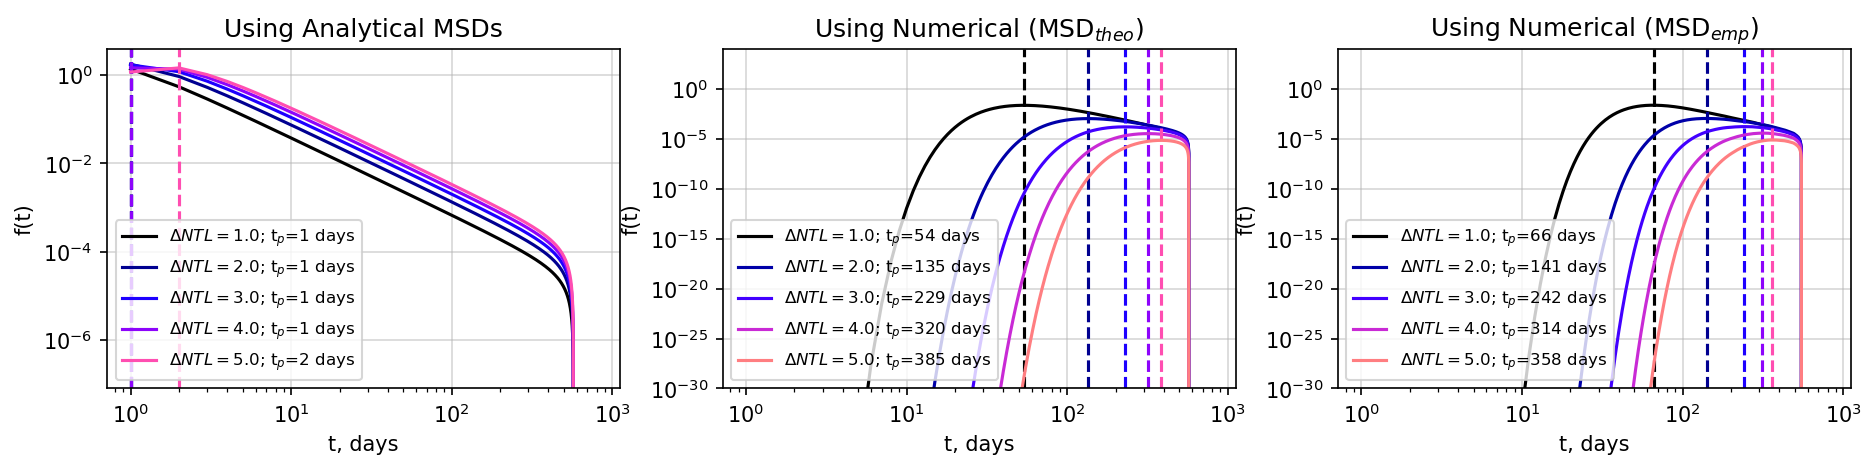

In [33]:
dx_vals = np.linspace(1,5,5)


plt.figure(figsize = (15,3), dpi = 150)
plt.subplot(131)
for i, dx in enumerate(dx_vals):
    FPTD = fptd(dx, x_samp, fit_v, fit_mu, fit_N)
    ipeak = np.argmax(FPTD)
    t_peak = x_samp[ipeak]
    plt.axvline(t_peak, ls='--', color =  plt.cm.gnuplot2(i/(len(dx_vals)+2)))
    plt.plot(x_samp, FPTD, color = plt.cm.gnuplot2(i/(len(dx_vals)+2)),
             label=r"$\Delta NTL=$"+"%.1f; t$_p$=%.f days" % (dx,t_peak))
    plt.legend(fontsize = 8)
plot_in_log()
plt.xlabel('t, days')
plt.ylabel('f(t)')
plt.title('Using Analytical MSDs')

plt.subplot(132)
for i, dx in enumerate(dx_vals):
    FPTD_ = fptd_(dx, MSD_theo, fit_v, fit_mu, fit_N)
    ipeak = np.argmax(FPTD_)
    t_peak = x_samp[ipeak]
    plt.axvline(t_peak, ls='--', color =  plt.cm.gnuplot2(i/(len(dx_vals)+2)))
    plt.plot(x_samp, FPTD_, color = plt.cm.gnuplot2(i/(len(dx_vals)+1)),
             label=r"$\Delta NTL=$"+"%.1f; t$_p$=%.f days" % (dx,t_peak))
    plt.legend(fontsize = 8)
plot_in_log()
plt.ylim(1e-30,1e4)
plt.xlabel('t, days')
plt.ylabel('f(t)')
plt.title('Using Numerical (MSD$_{theo}$)')

plt.subplot(133)
for i, dx in enumerate(dx_vals):
    FPTD__ = fptd_(dx, y_samp, fit_v, fit_mu, fit_N)
    ipeak = np.argmax(FPTD__)
    t_peak = x_samp[ipeak]
    plt.axvline(t_peak, ls='--', color =  plt.cm.gnuplot2(i/(len(dx_vals)+2)))
    plt.plot(x_samp, FPTD__, color = plt.cm.gnuplot2(i/(len(dx_vals)+1)),
             label=r"$\Delta NTL=$"+"%.1f; t$_p$=%.f days" % (dx,t_peak))
    plt.legend(fontsize = 8)
plot_in_log()
plt.ylim(1e-30,1e4)
plt.xlabel('t, days')
plt.ylabel('f(t)')
plt.title('Using Numerical (MSD$_{emp}$)')

In [34]:
# # MSD_params
# MSD_params['fit_v'], MSD_params['fit_mu'], MSD_params['fit_n']

# Numerical FPTD

## FPTD: Empirical MSD

Plotting MSD: 15it [00:00, 90.30it/s]


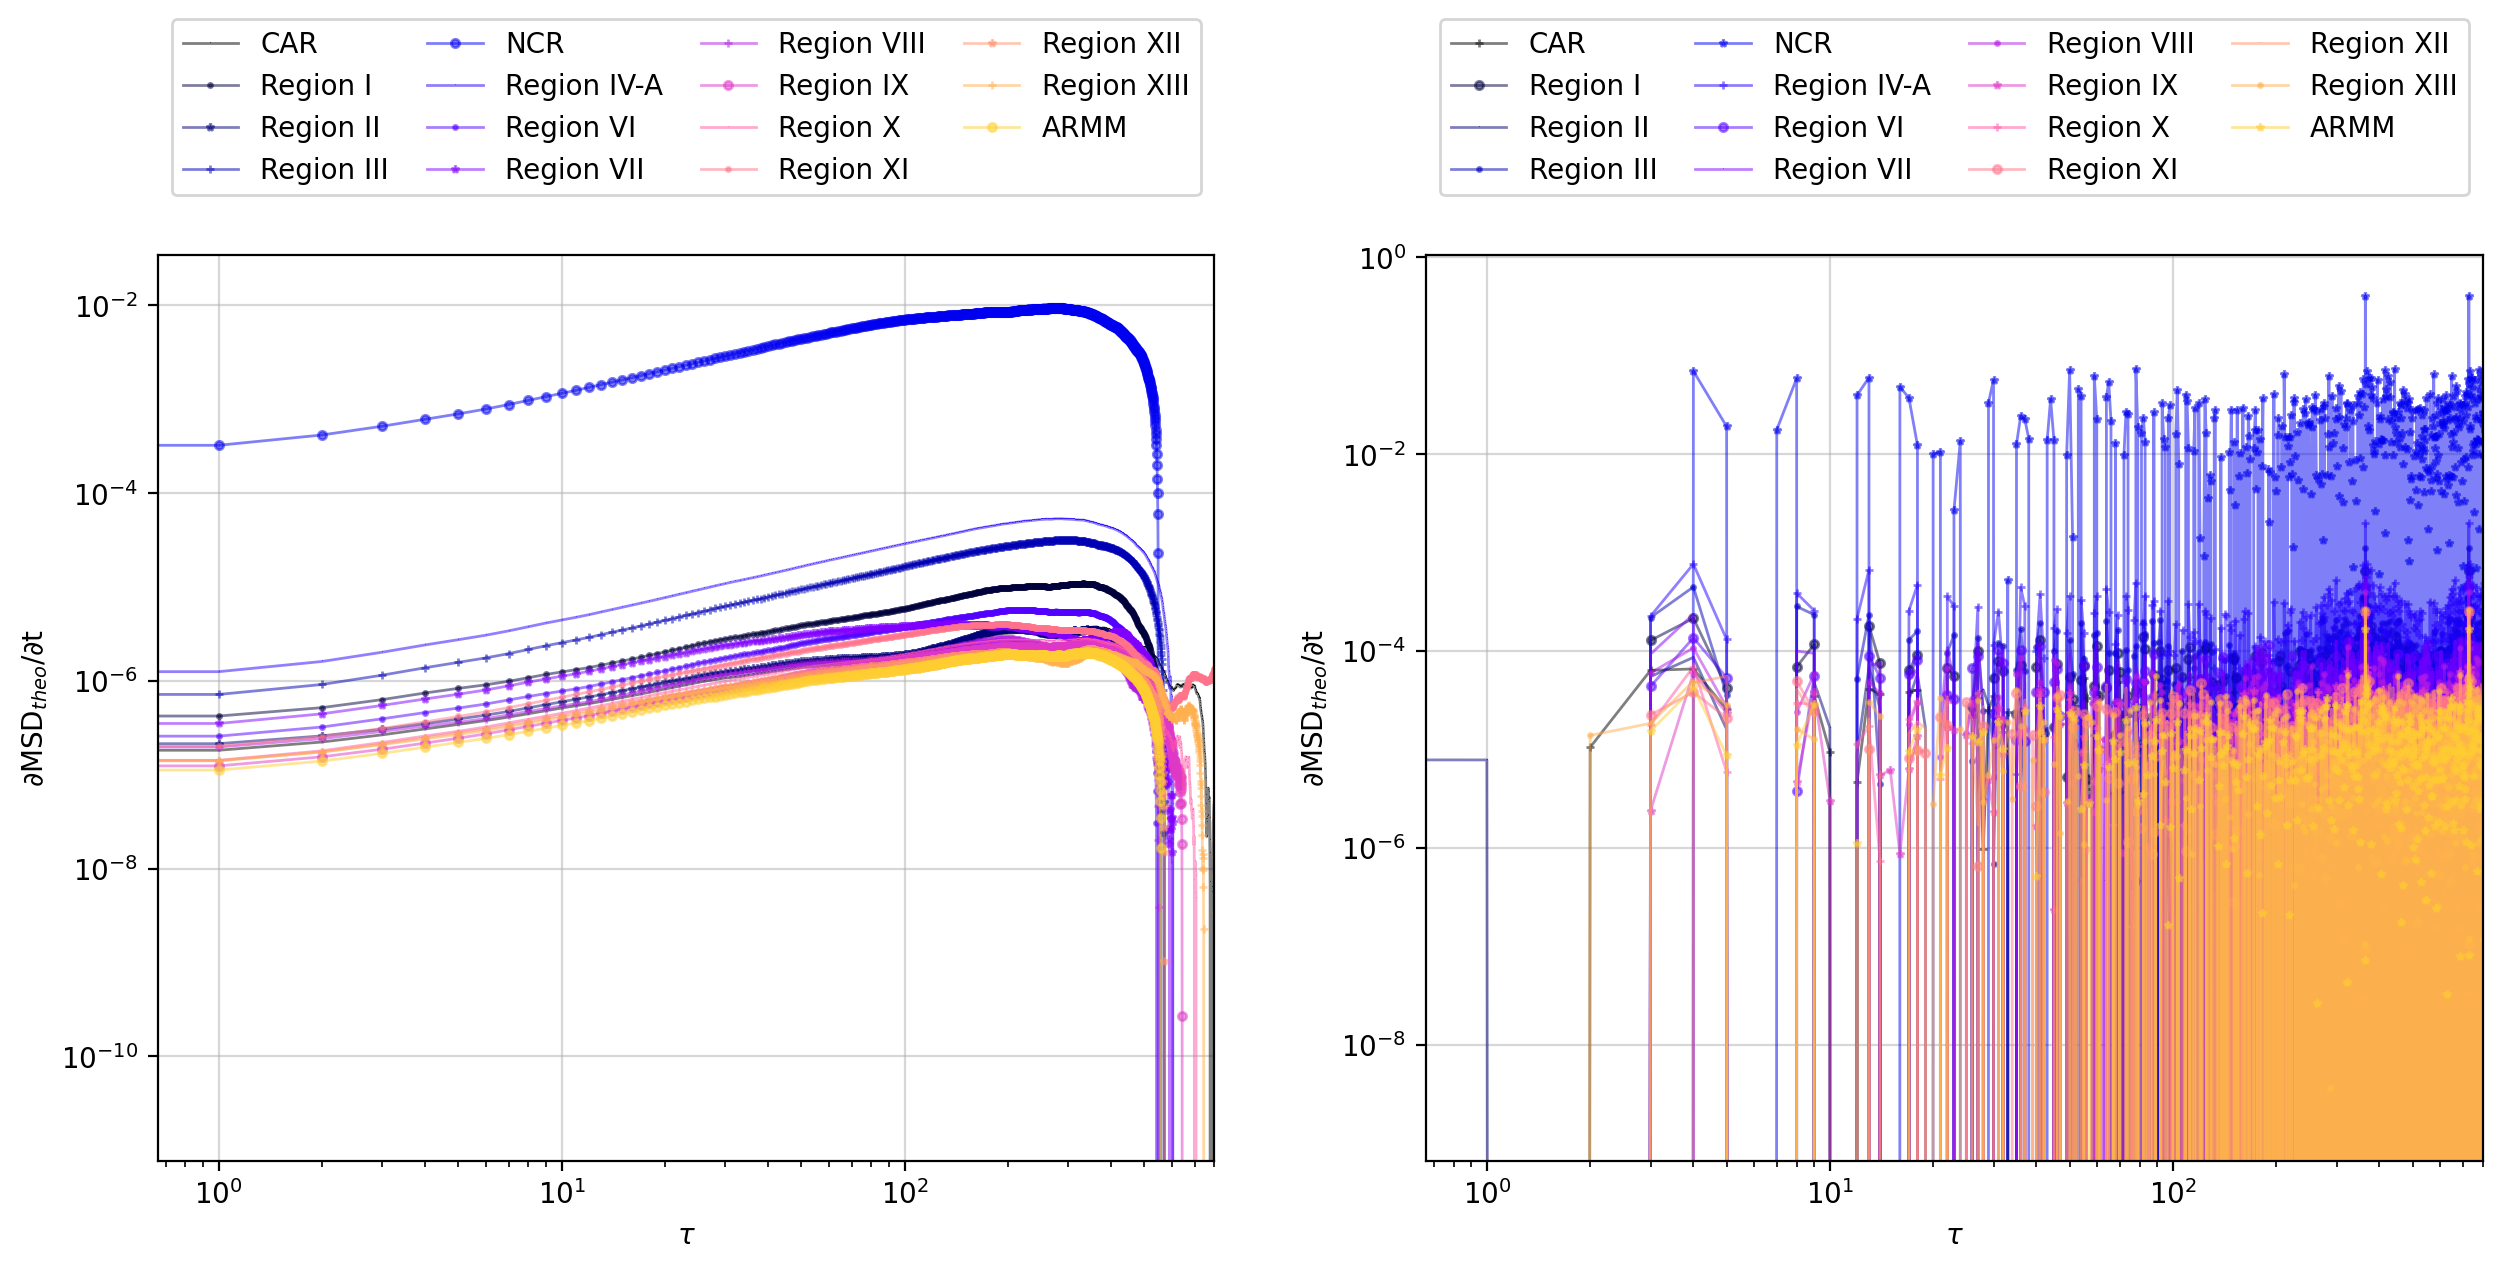

In [35]:
fig = plt.figure(dpi = 200, figsize = (15,6))
fig.patch.set_facecolor('None')

for i, loc in tqdm(enumerate(MSD_trend_df.columns), desc = 'Plotting MSD'):
    plt.subplot(121)
    plt.plot(np.gradient(MSD_trend_df[loc]), '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    plot_in_log()
    plot_labels()
    plt.ylabel('$\partial$MSD$_{theo}$/$\partial$t')
    plt.xlim(0,800)

    
    plt.subplot(122)
    plt.plot(np.gradient(MSD_seasonality_df[loc]), '-', label = loc, lw = 1,
             color = plt.cm.gnuplot2(i/17), ms = 3, alpha = 0.5, marker = next(marker))
    plt.legend(fontsize=10, ncol = 4, bbox_to_anchor= (0, 1.05, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
    plot_in_log()
    plot_labels()
    plt.ylabel('$\partial$MSD$_{theo}$/$\partial$t')
    plt.xlim(0,800)

In [36]:
dx_vals = np.linspace(0.05,0.5, 10)
# dx_vals = np.logspace(-2,-0.5,10)
cols = ["%.2f" % i for i in dx_vals]
dx_vals

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [37]:
ftpd_emp = pd.DataFrame([], index = regions, 
                          columns = cols)

In [38]:
dx_vals = np.linspace(0.01,0.1,4) #FOR PLOTTING
dx_vals

array([0.01, 0.04, 0.07, 0.1 ])

Processing: CAR: 10it [00:00, 517.98it/s]
Processing: Region I: 10it [00:00, 745.56it/s]
Processing: Region II: 10it [00:00, 734.93it/s]
Processing: Region III: 10it [00:00, 447.93it/s]
Processing: NCR: 10it [00:00, 762.32it/s]
Processing: Region IV-A: 10it [00:00, 610.10it/s]
Processing: Region VI: 10it [00:00, 728.76it/s]
Processing: Region VII: 10it [00:00, 770.26it/s]
Processing: Region VIII: 10it [00:00, 739.49it/s]
Processing: Region IX: 10it [00:00, 708.77it/s]
Processing: Region X: 10it [00:00, 618.93it/s]
Processing: Region XI: 10it [00:00, 714.30it/s]
Processing: Region XII: 10it [00:00, 744.26it/s]
Processing: Region XIII: 10it [00:00, 774.30it/s]
Processing: ARMM: 10it [00:00, 778.77it/s]


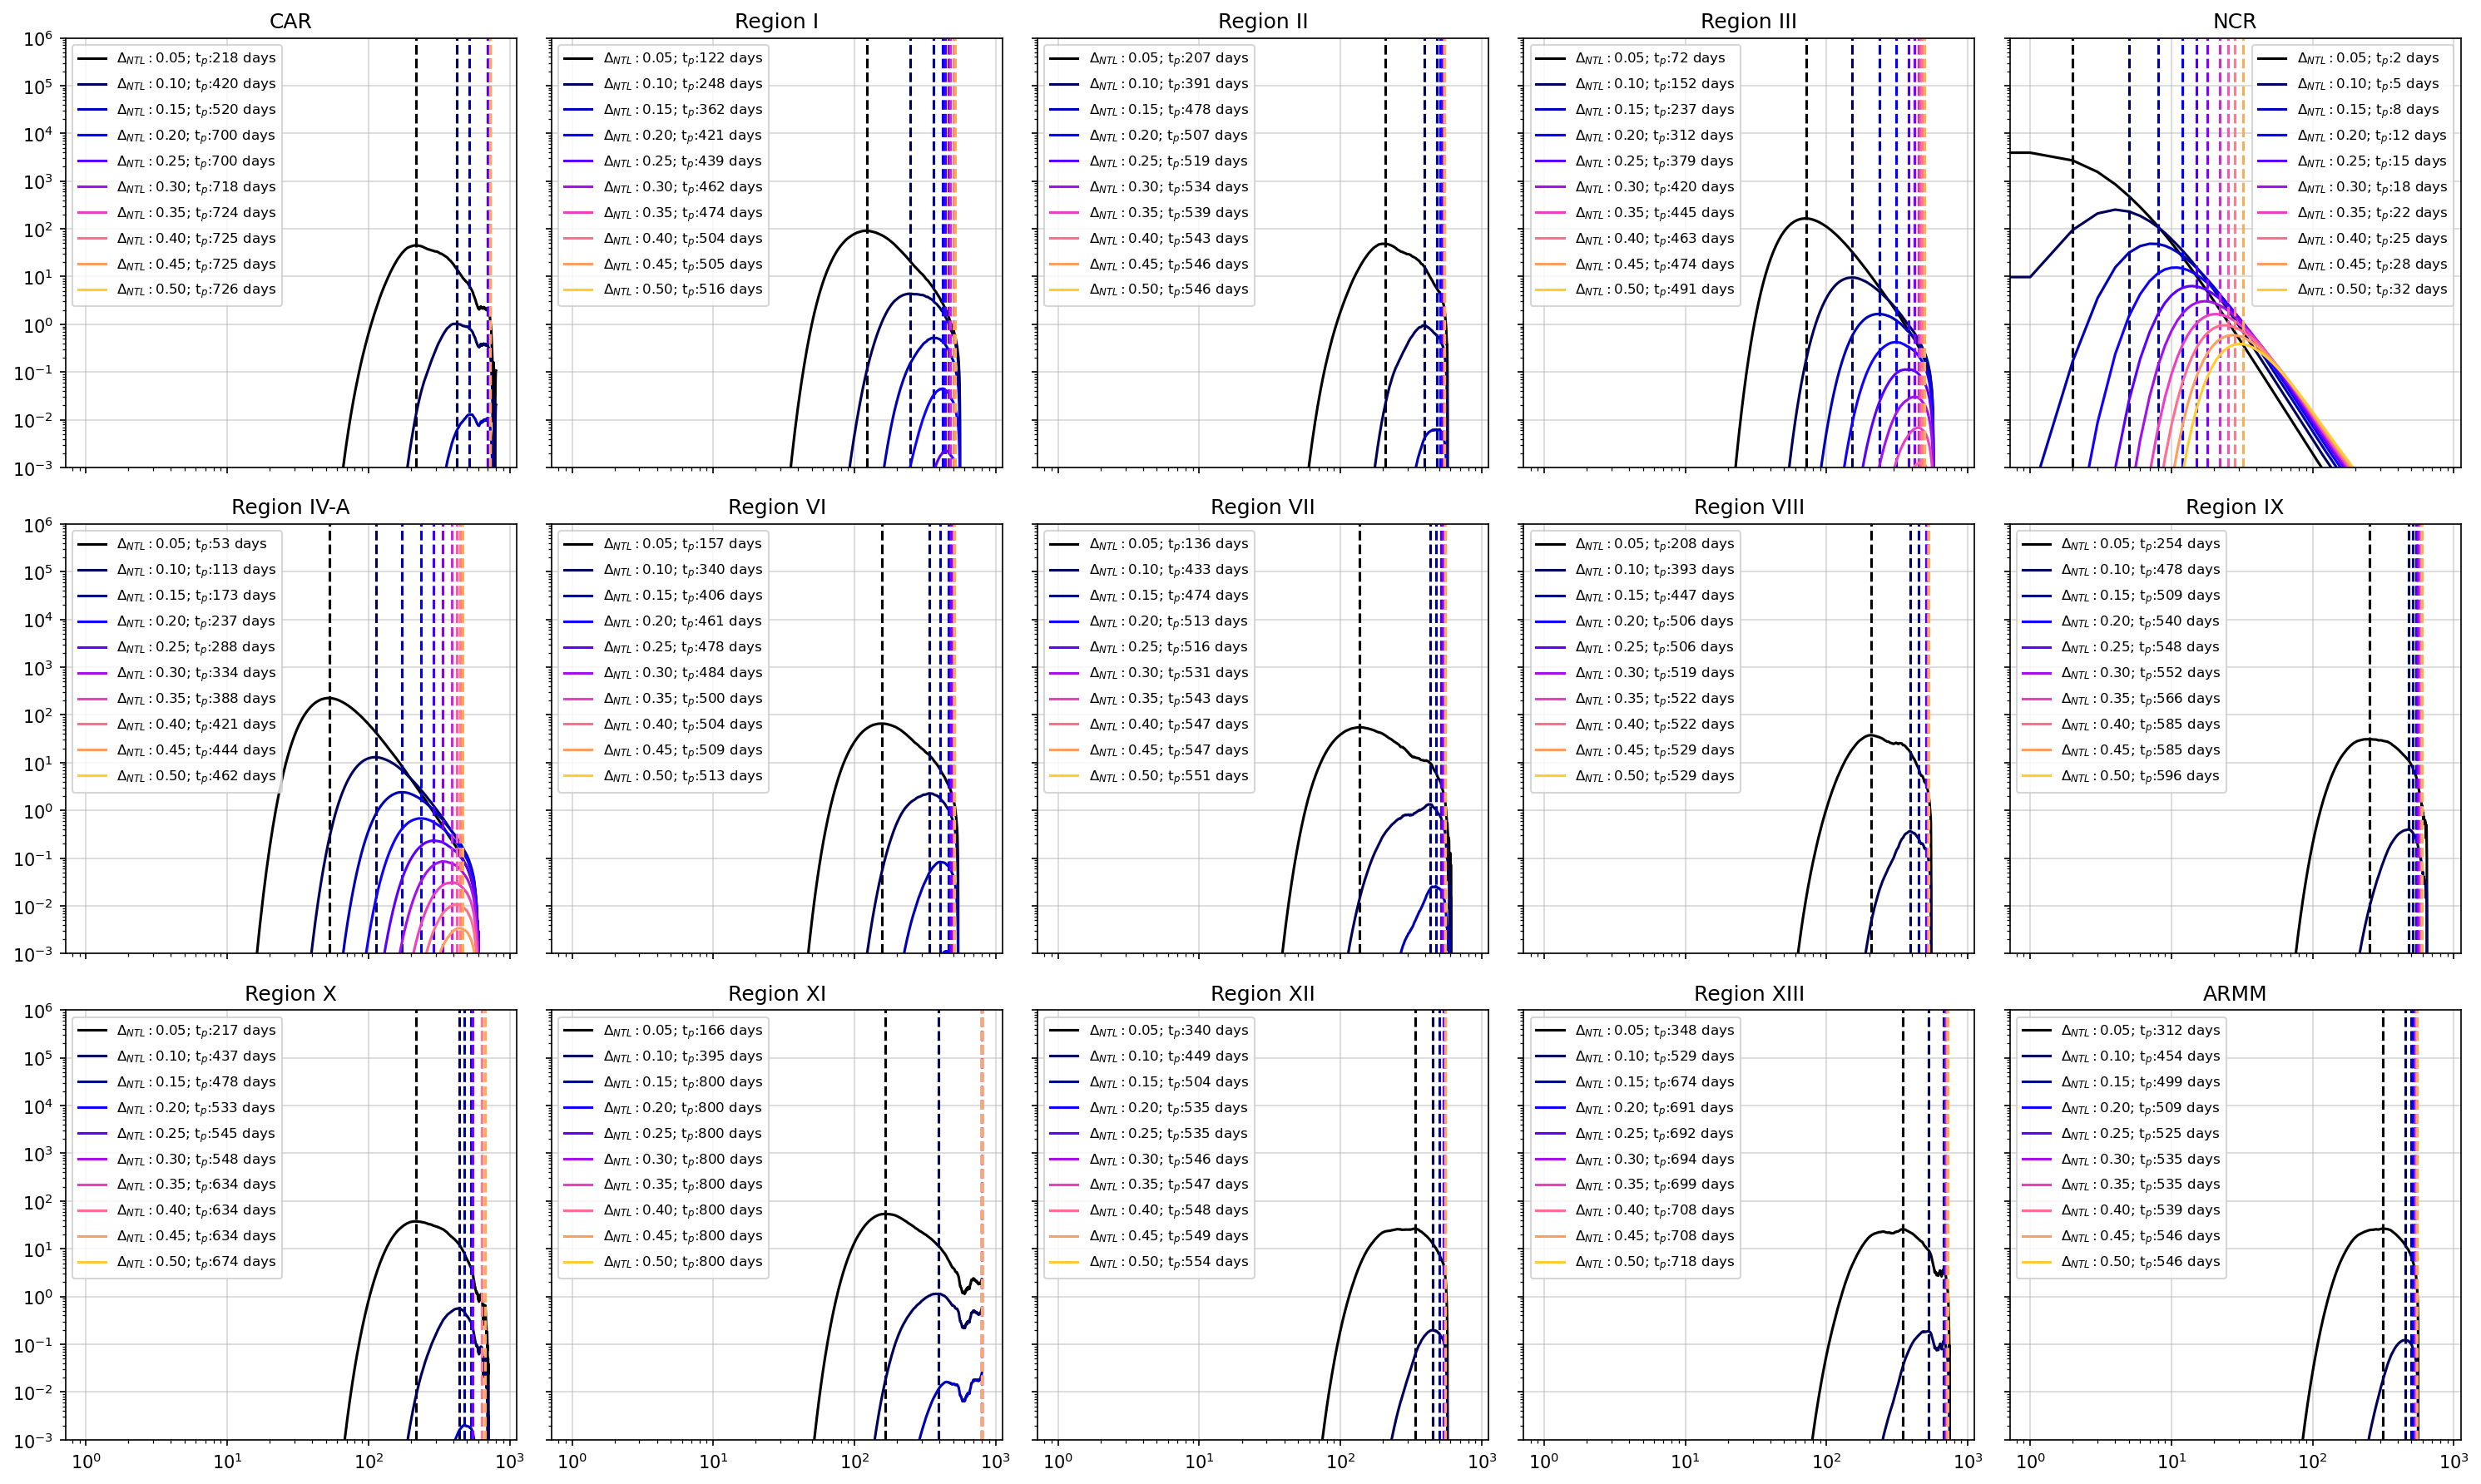

In [46]:
fig, axes = plt.subplots(nrows=3,ncols=5, sharex='col', sharey='row',
                         figsize = (20,12), dpi = 150)

for i, ax in enumerate(axes.ravel()):
    
    region = regions[i]
    m = empirical_MSDs[region].values[:800]
    
    ax.set_title(str(region))
    ax.grid(alpha = 0.5)

    t_peaks = []
    
    for j, dx in tqdm(enumerate(dx_vals), desc = 'Processing: ' + str(region)):

        term_1 = np.abs(dx)/(np.sqrt(2 * np.pi)* m**3) 
        MSD_prime = np.gradient(m)
        term_3 = np.exp(-(dx**2)/(2 * m))
        fptd = term_1*MSD_prime*term_3

        ipeak = np.argmax(fptd)
        t_peak = x_samp[ipeak]
        
        t_peaks.append(t_peak)
        
        ax.axvline(t_peak, ls='--', color =  plt.cm.gnuplot2(j/(len(dx_vals)+2)))
        ax.plot(fptd, color = plt.cm.gnuplot2(j/(len(dx_vals)+1)),
                 label=r"$\Delta_{NTL}:$"+"%.2f; t$_p$:%.f days" % (dx,t_peak))
        
    '''UNCOMMENT THIS LINE WHEN GENERATING PLOTS''' 
    ftpd_emp.loc[region] = t_peaks
    '''UNCOMMENT THUS LINE WHEN GENERATING PLOTS''' 

    ax.legend(fontsize = 8)
    ax.set_ylim(1e-3,1e6)

    ax.set_xscale('log')
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [47]:
ftpd_emp = ftpd_emp.apply(pd.to_numeric, errors='coerce')
ftpd_emp

0.05   0.10   0.15   0.20   0.25   0.30   0.35   0.40   0.45  \
CAR          218.0  420.0  520.0  700.0  700.0  718.0  724.0  725.0  725.0   
Region I     122.0  248.0  362.0  421.0  439.0  462.0  474.0  504.0  505.0   
Region II    207.0  391.0  478.0  507.0  519.0  534.0  539.0  543.0  546.0   
Region III    72.0  152.0  237.0  312.0  379.0  420.0  445.0  463.0  474.0   
NCR            2.0    5.0    8.0   12.0   15.0   18.0   22.0   25.0   28.0   
Region IV-A   53.0  113.0  173.0  237.0  288.0  334.0  388.0  421.0  444.0   
Region VI    157.0  340.0  406.0  461.0  478.0  484.0  500.0  504.0  509.0   
Region VII   136.0  433.0  474.0  513.0  516.0  531.0  543.0  547.0  547.0   
Region VIII  208.0  393.0  447.0  506.0  506.0  519.0  522.0  522.0  529.0   
Region IX    254.0  478.0  509.0  540.0  548.0  552.0  566.0  585.0  585.0   
Region X     217.0  437.0  478.0  533.0  545.0  548.0  634.0  634.0  634.0   
Region XI    166.0  395.0  800.0  800.0  800.0  800.0  800.0  800.0  800.0   
Region XII   340.0  449.0  504.0  535.0  535.0  546.0  547.0  548.0  549.0   
Region XIII  348.0  529.0  674.0  691.0  692.0  694.0  699.0  708.0  708.0   
ARMM         312.0  454.0  499.0  509.0  525.0  535.0  535.0  539.0  546.0   

              0.50  
CAR          726.0  
Region I     516.0  
Region II    546.0  
Region III   491.0  
NCR           32.0  
Region IV-A  462.0  
Region VI    513.0  
Region VII   551.0  
Region VIII  529.0  
Region IX    596.0  
Region X     674.0  
Region XI    800.0  
Region XII   554.0  
Region XIII  718.0  
ARMM         546.0

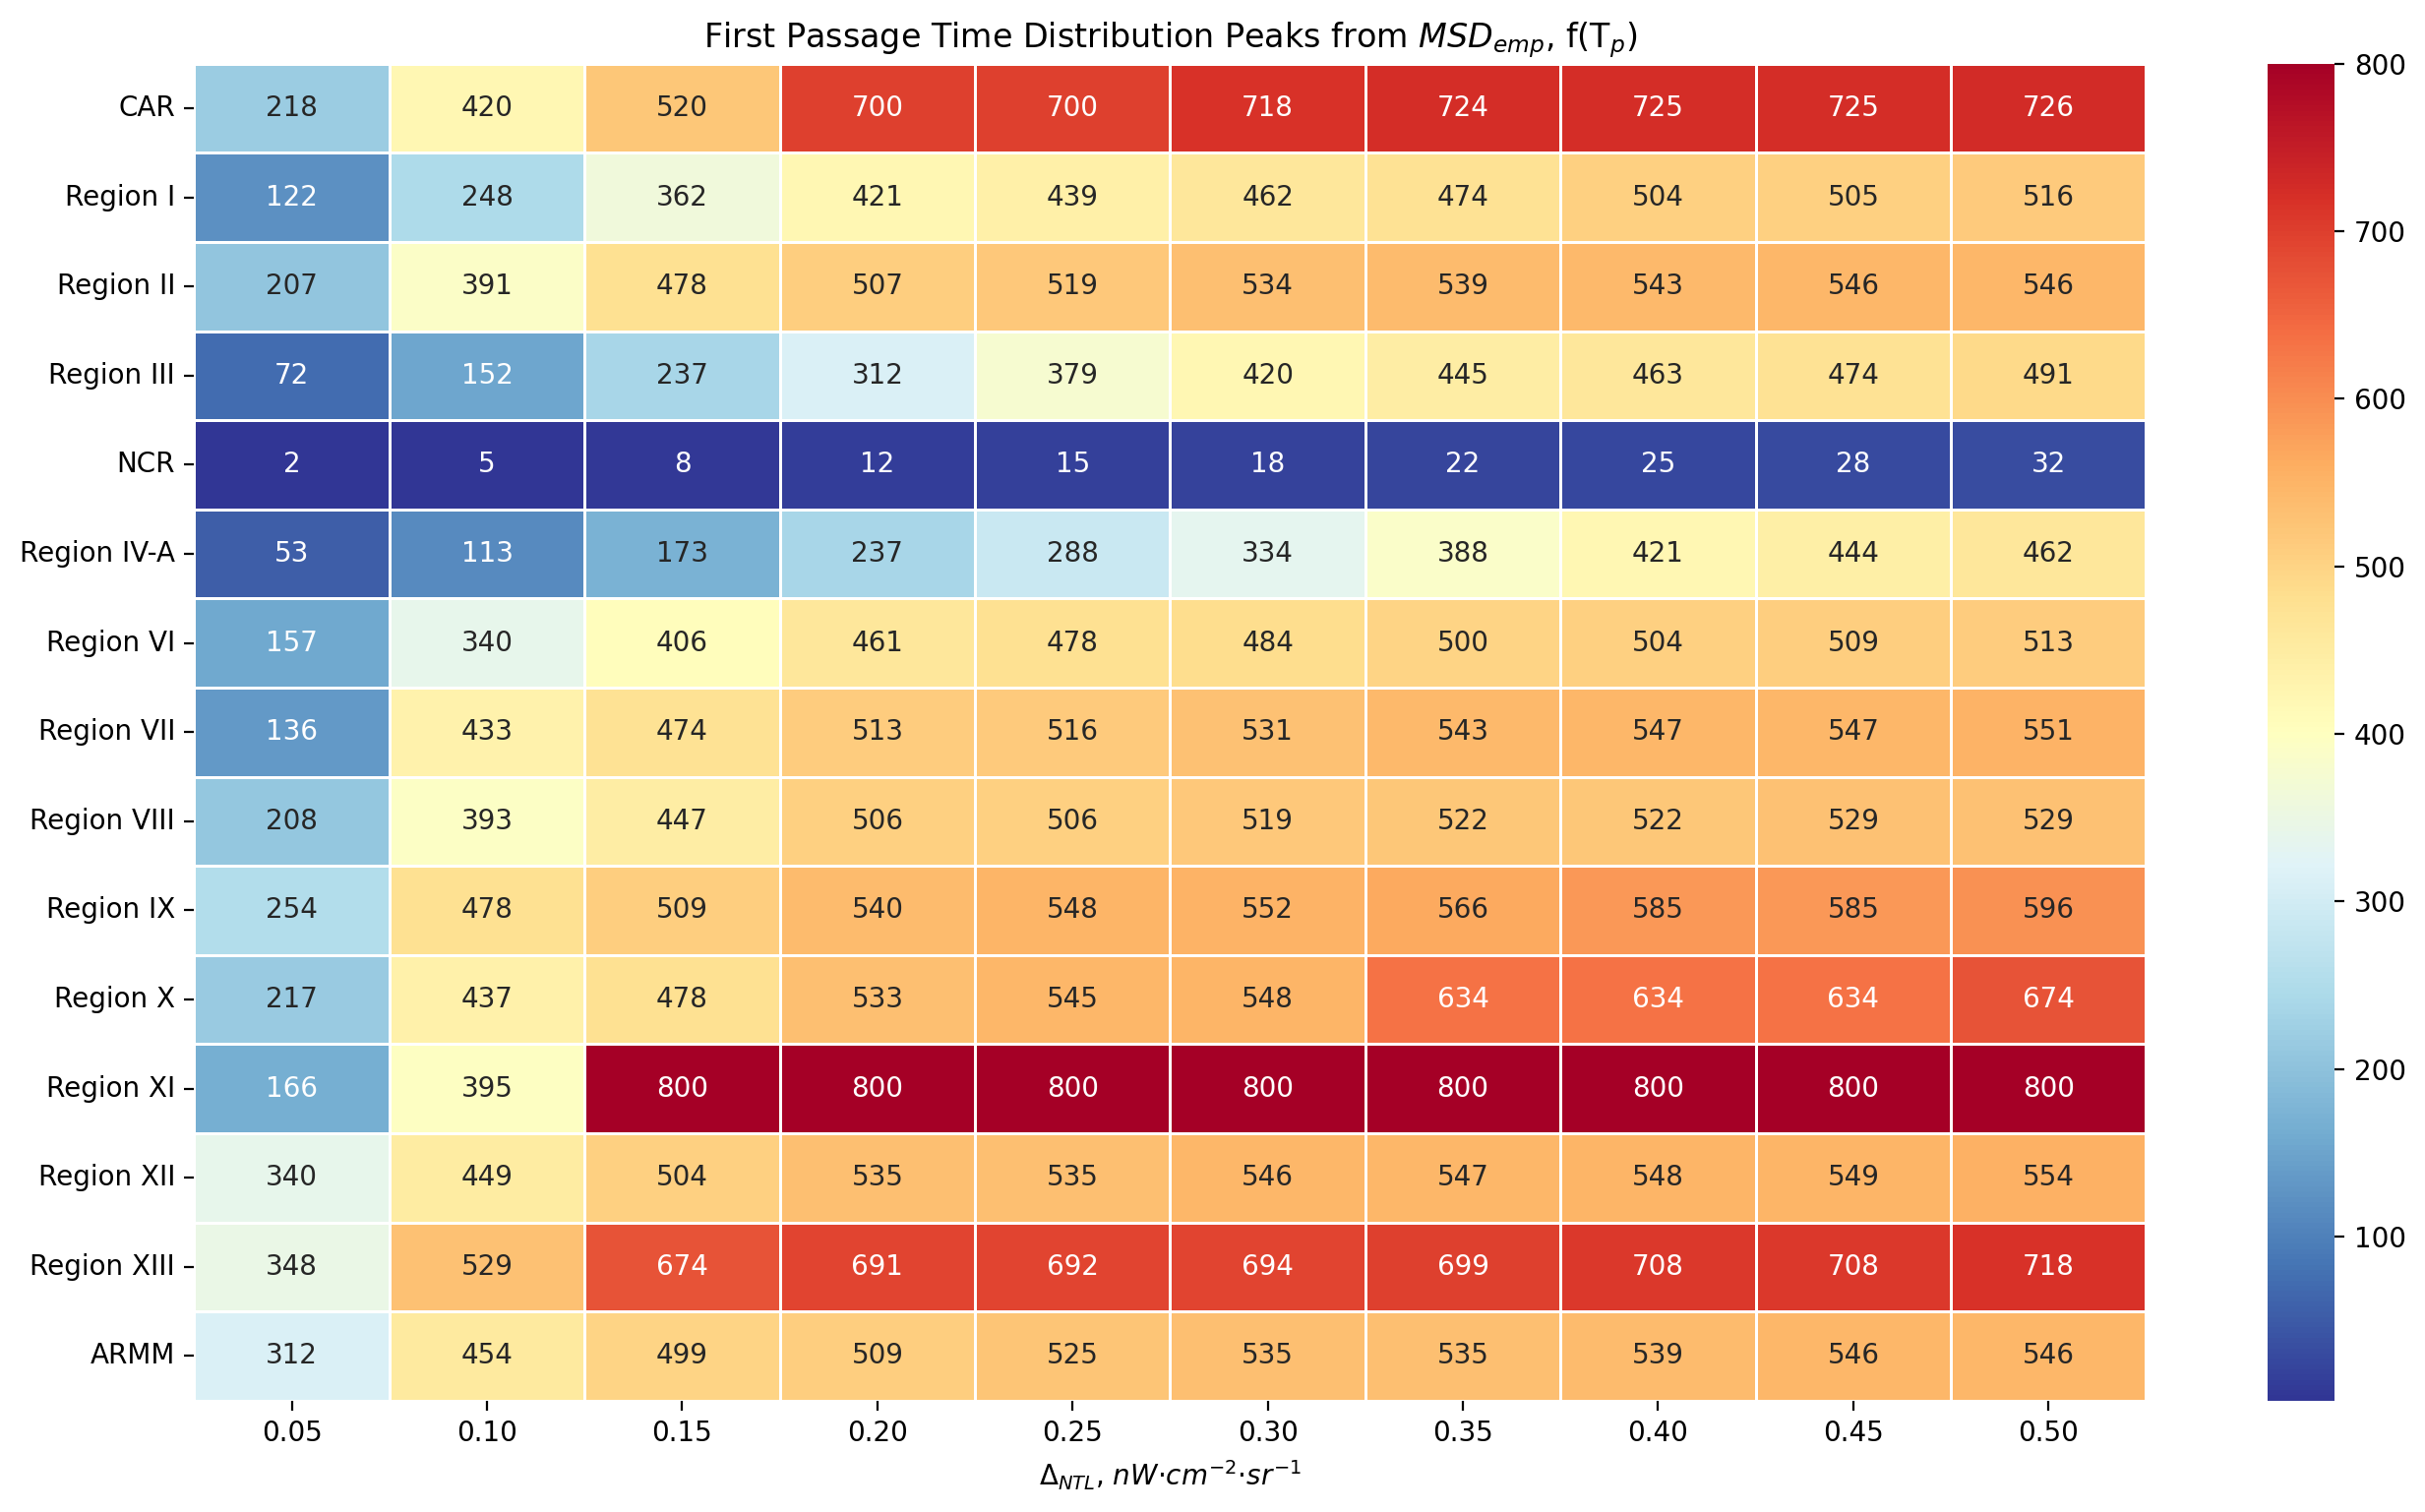

In [48]:
# from matplotlib.colors import LogNorm
plt.figure(figsize=(16, 9), dpi = 200)
sns.heatmap(ftpd_emp, annot=True, fmt='g', cmap='RdYlBu_r', linewidths=.5, vmax = 800)
plt.title('First Passage Time Distribution Peaks from $MSD_{emp}$, f(T$_p$)')
plt.xlabel('$\Delta_{NTL}$, $nW·cm^{−2}·sr^{−1}$')
plt.show()

## FPTD: Theoretical MSD

In [136]:
ftpd_theo = pd.DataFrame([], index = regions, 
                          columns = cols)

In [137]:
# fit_v, fit_mu, fit_N = MSD_params['fit_v'], MSD_params['fit_mu'], MSD_params['fit_N']
# fit_v

Processing: CAR: 10it [00:00, 640.70it/s]
Processing: Region I: 10it [00:00, 777.79it/s]
Processing: Region II: 10it [00:00, 795.91it/s]
Processing: Region III: 10it [00:00, 813.94it/s]
Processing: NCR: 10it [00:00, 827.74it/s]
Processing: Region IV-A: 10it [00:00, 446.74it/s]
Processing: Region VI: 10it [00:00, 770.64it/s]
Processing: Region VII: 10it [00:00, 793.47it/s]
Processing: Region VIII: 10it [00:00, 766.57it/s]
Processing: Region IX: 10it [00:00, 720.40it/s]
Processing: Region X: 10it [00:00, 608.82it/s]
Processing: Region XI: 10it [00:00, 703.93it/s]
Processing: Region XII: 10it [00:00, 706.56it/s]
Processing: Region XIII: 10it [00:00, 736.22it/s]
Processing: ARMM: 10it [00:00, 727.02it/s]


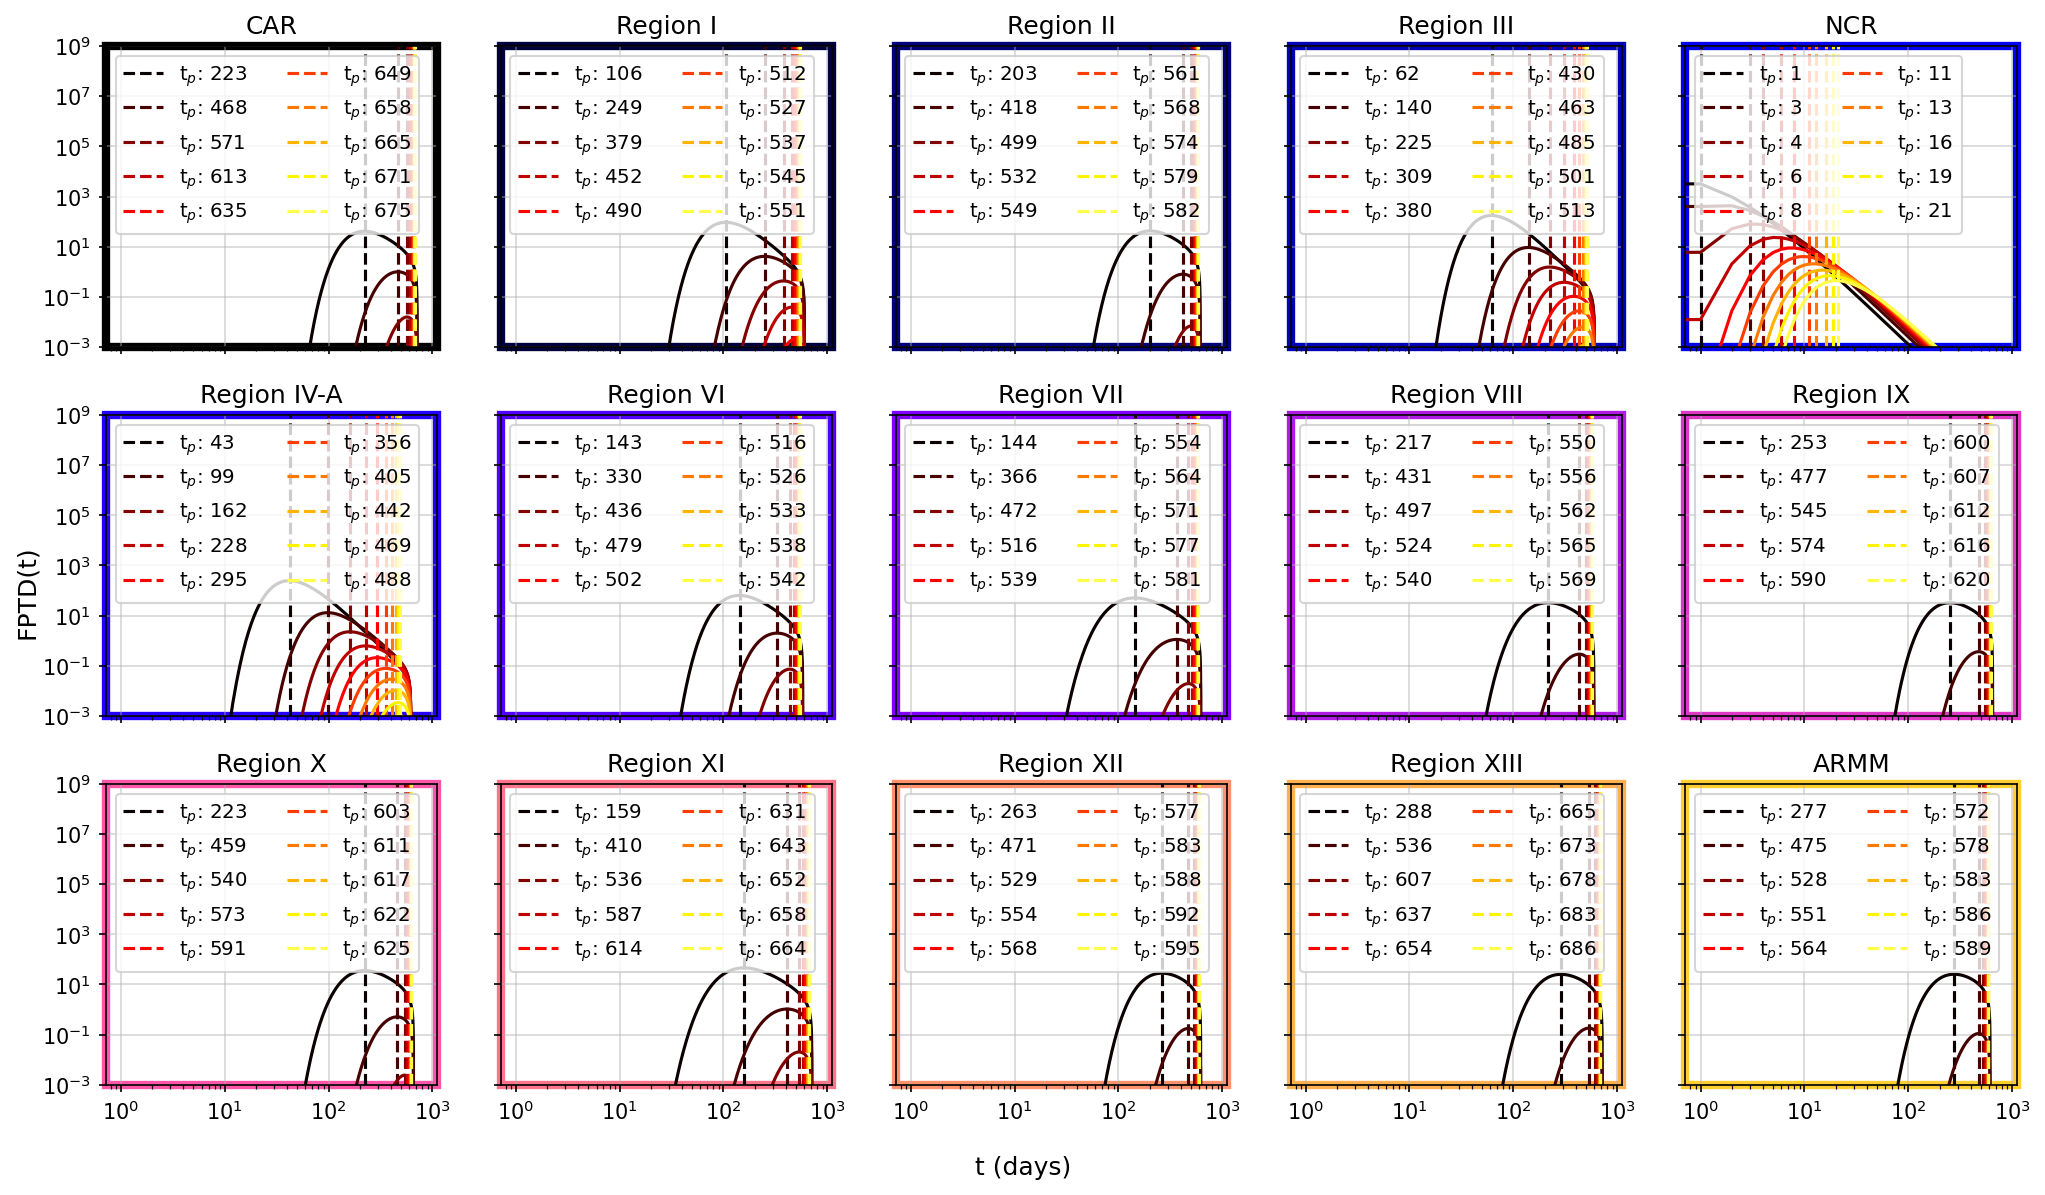

In [138]:
# dx_vals = np.linspace(0.01,0.11,4) #FOR PLOTTING
# dx_vals

fig, axes = plt.subplots(nrows=3,ncols=5, sharex='col', sharey='row',
                         figsize = (14,8), dpi = 150)

for i, ax in enumerate(axes.ravel()):
    
    region = regions[i]
    msd_params = MSD_params.loc[region]
    
    fit_v, fit_mu, fit_N = msd_params['fit_v'], msd_params['fit_mu'], msd_params['fit_N']
    msd_theo = msd_theo_ntl(x_samp, fit_v, fit_mu, fit_N)
    
    ax.set_title(str(region), color = 'k', fontsize = 12)
    ax.grid(alpha = 0.5)

    t_peaks = []
    
    for j, dx in tqdm(enumerate(dx_vals), desc = 'Processing: ' + str(region)):


        fptd = fptd_(dx, msd_theo, fit_v, fit_mu, fit_N)
        
        ipeak = np.argmax(fptd)
        t_peak = x_samp[ipeak]
        
        t_peaks.append(t_peak)
        
        ax.axvline(t_peak, ls='--', color =  plt.cm.hot(j/(len(dx_vals)+1)),
                   label= "t$_p$: %.f" % (t_peak))
        ax.plot(fptd, color = plt.cm.hot(j/(len(dx_vals)+1)))
        
    '''UNCOMMENT THIS LINE WHEN GENERATING PLOTS''' 
    ftpd_theo.loc[region] = t_peaks
    '''UNCOMMENT THUS LINE WHEN GENERATING PLOTS''' 

    ax.legend(loc = 'upper left', fontsize = 9.5, ncol = 2, bbox_transform=plt.gca().transAxes,
              facecolor = 'white', fancybox = True)
    ax.set_ylim(1e-3,1e9)

    ax.set_xscale('log')
    ax.set_yscale('log')
    
  
    ax.patch.set(lw=4, ec=plt.cm.gnuplot2(i/17))
    
fig.supxlabel('t (days)')
fig.supylabel('FPTD(t)')
plt.tight_layout()
plt.show()

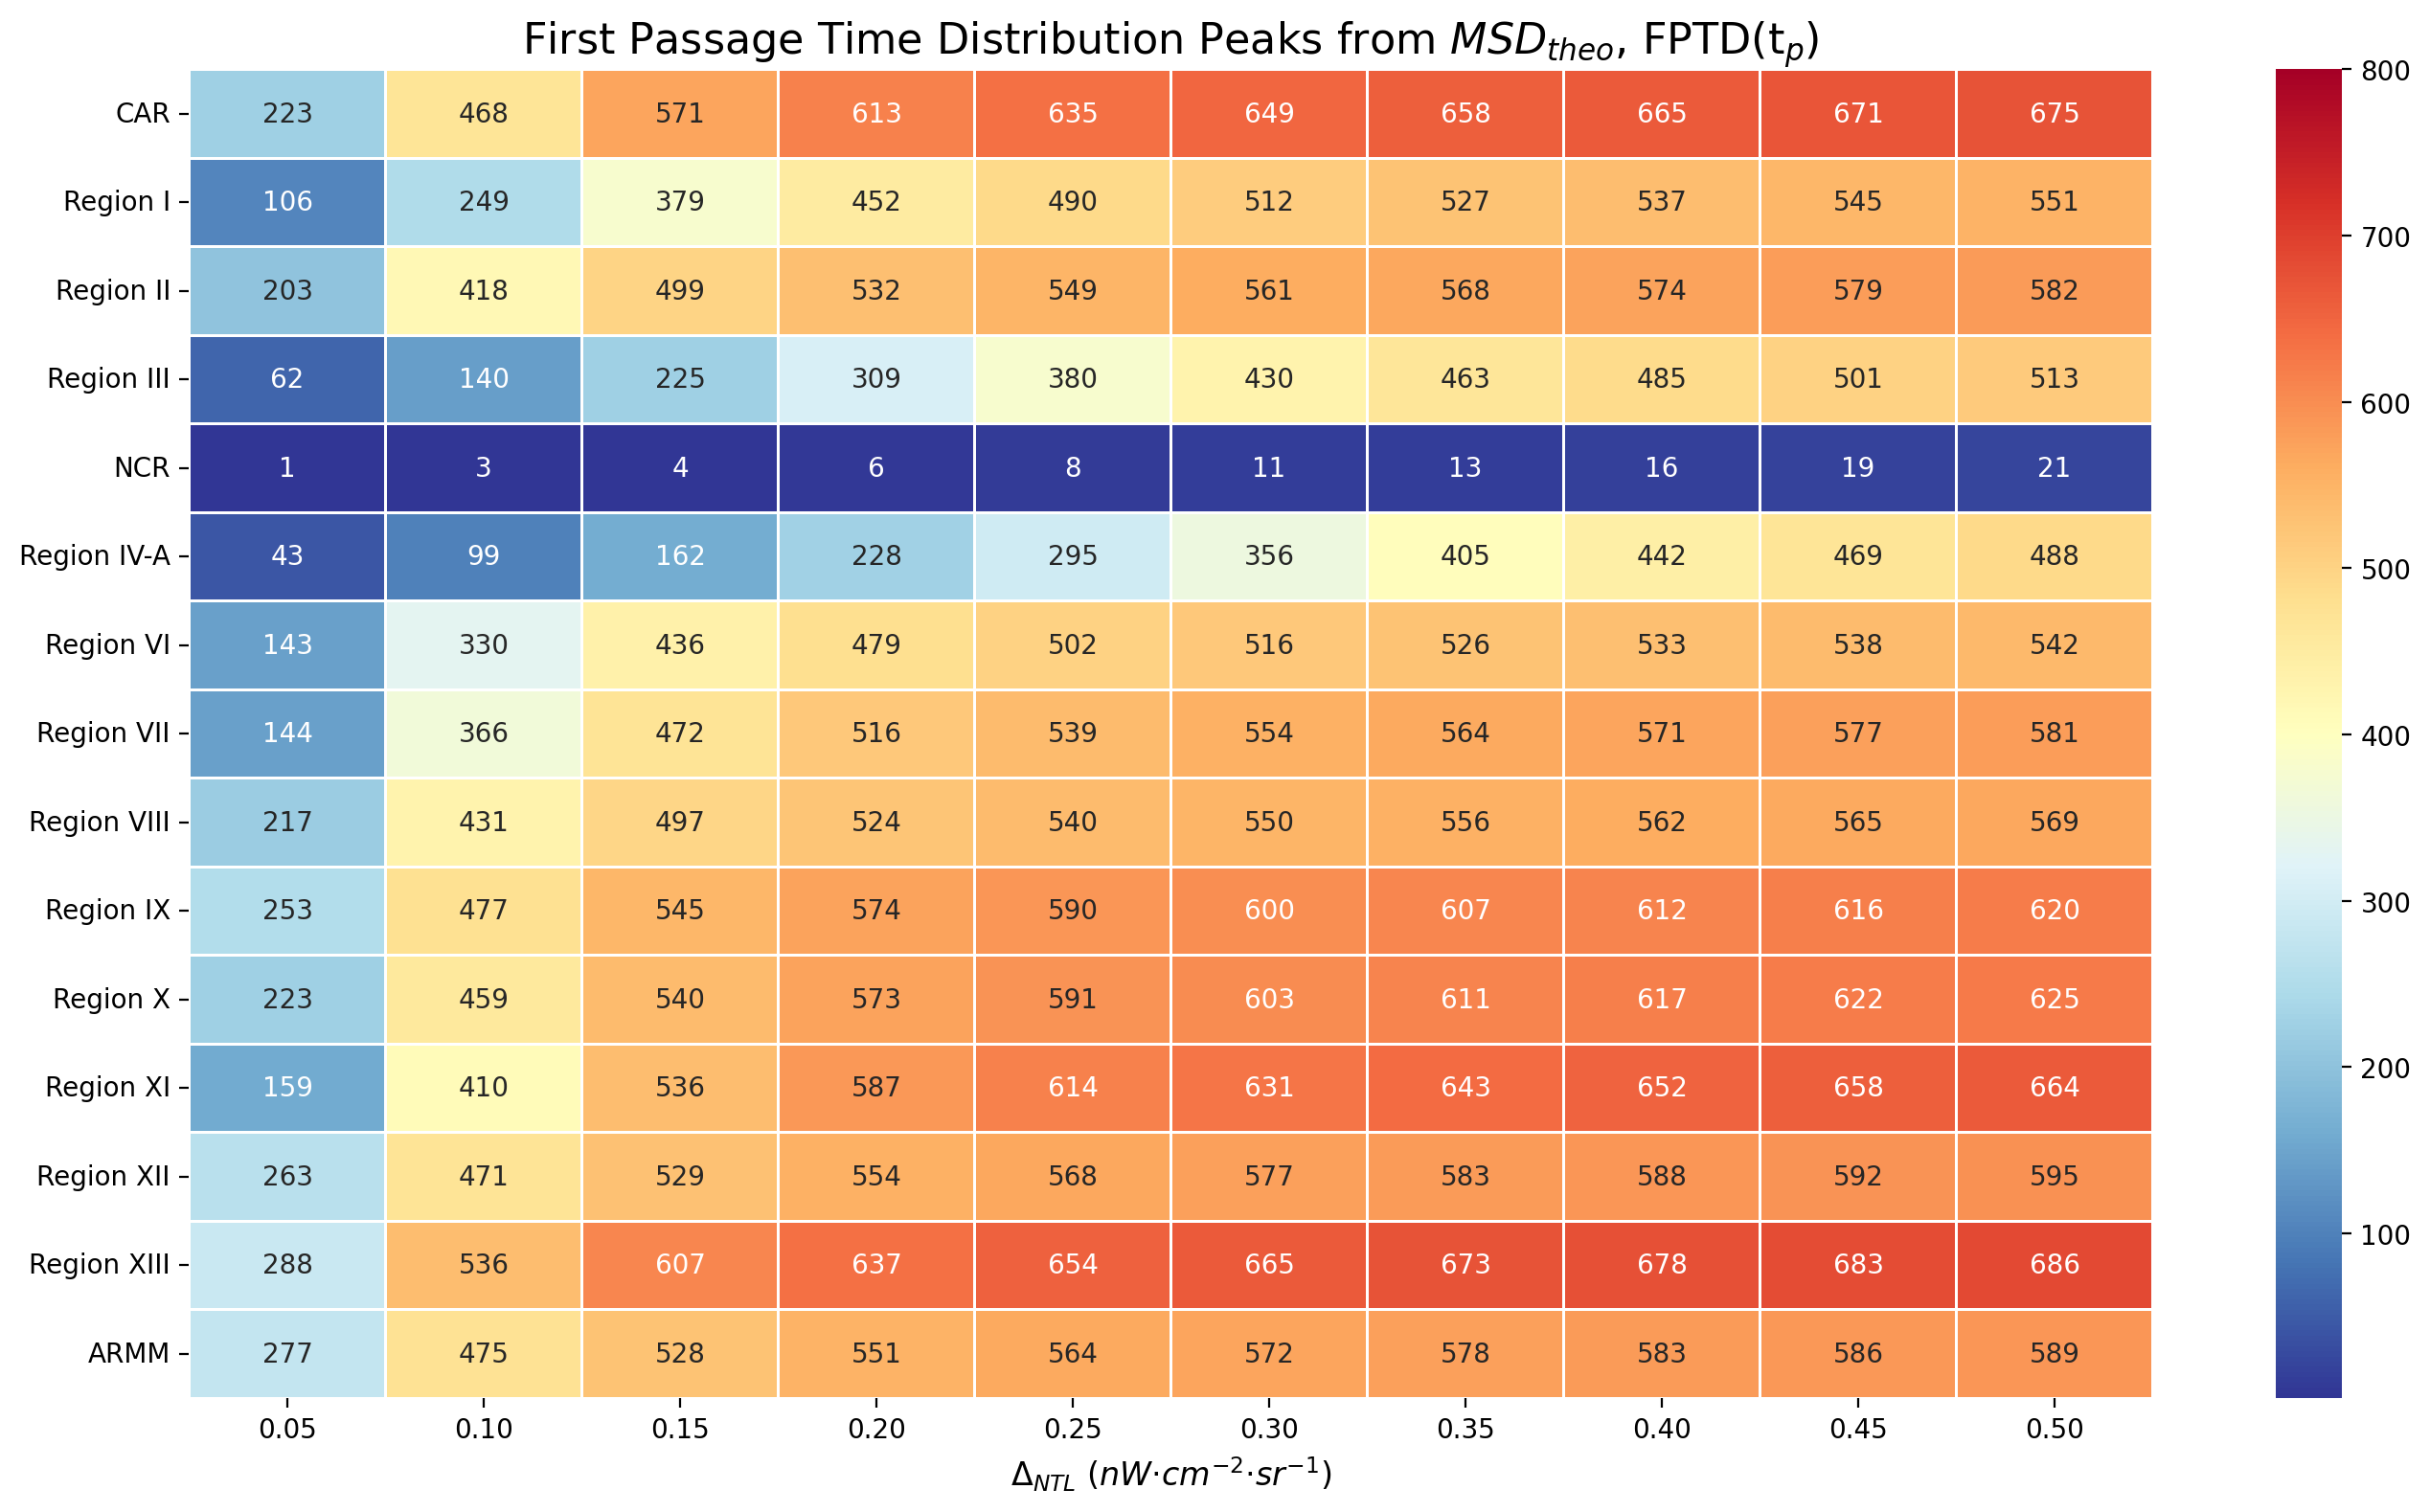

In [140]:
ftpd_theo = ftpd_theo.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(14, 8), dpi = 200)
sns.heatmap(ftpd_theo, annot=True, fmt='g', cmap='RdYlBu_r', linewidths=.5, vmax = 800)
plt.title('First Passage Time Distribution Peaks from $MSD_{theo}$, FPTD(t$_p$)', fontsize = 16)
plt.xlabel('$\Delta_{NTL}$ ($nW·cm^{−2}·sr^{−1})$', fontsize = 12)

plt.tight_layout()
plt.show()

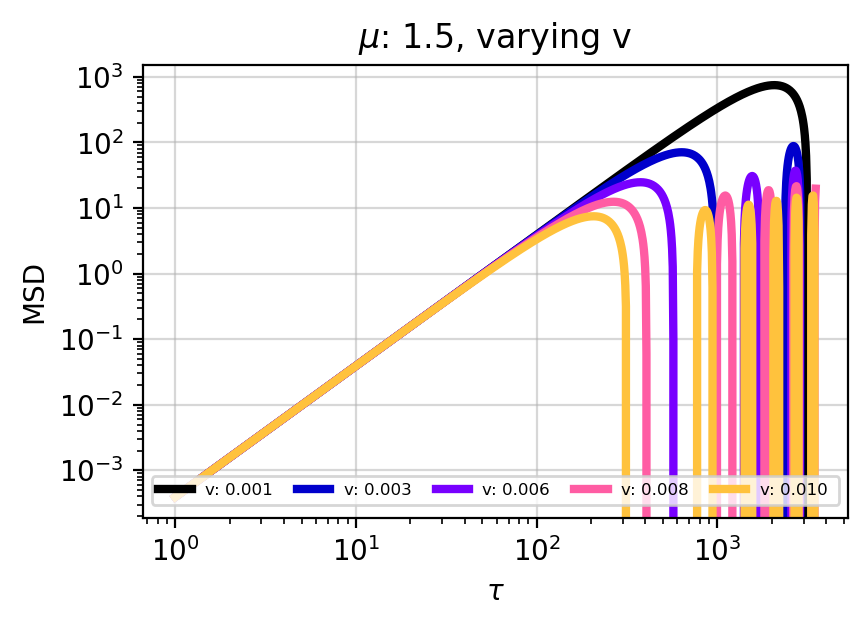

In [27]:
t = np.logspace(0, np.log10(3500), 1000)
v_vals = np.linspace(0.001,0.01,5)
mu_vals = np.linspace(0.5,9.5,10)
N = 1e-3

fig = plt.figure(dpi = 200, figsize = (10,3))
fig.patch.set_facecolor('None')

plt.subplot(121)
for i,v in enumerate(v_vals):
    mu = 1.5
    plt.plot(t, msd_theo_ntl(t,v,mu, N), '-', color = plt.cm.gnuplot2((i)/len(v_vals)), lw = 3,
             label = r"v: %.3f " % (v))
    plt.title(r"$\mu$: %.1f, varying v" % (mu))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=6, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    

In [28]:
v = 0.003
mu = 1.5

initial_ss = [v, mu]

n_tau = 1000

x_fit = tau_vals[:n_tau]
y_fit = emp_MSD[:n_tau]
# n_fit = len(i_fit)
popt, pcov = curve_fit(msd_theo_ntl, x_fit, y_fit, initial_ss, maxfev=5000)

fit_v, fit_mu = popt[0], popt[1]
err_v, err_mu = pcov[0,0]**0.5, pcov[1,1]**0.5

print("v = %.5f (%.5f), mu = %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))

y_fit = msd_theo_ntl(x_samp, fit_v, fit_mu)

TypeError: msd_theo_ntl() missing 1 required positional argument: 'N'

In [ ]:
plt.figure(figsize = (10,5), dpi = 150)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(x_samp, y_fit, 'r--', lw = 3, label = 'N =%.3f, tc =%1d' % (N_factor, tc))
plot_in_log()
plot_labels()
plt.title("Theoretical MSD, v: %.5f (%.5f), mu: %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))
plt.legend()

In [ ]:
# N_factor = (max(y_samp)-min(y_samp))/(max(msd_theo)-min(msd_theo))
# emp_peak = y_samp.tolist().index(max(y_samp))
# # theo_peak = msd_theo.tolist().index(max(msd_theo))
# # tc = x_samp[emp_peak]/t[theo_peak]
# tc = 10**2

In [ ]:
# plt.figure(figsize = (15,4), dpi = 150)
# plt.subplot(121)
# xx = np.logspace(np.log(1e-1), np.log(1.5), 1000)
# plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
# plt.plot(t, msd_theo_ntl(t, v,mu), 'r.', label = 'v = 1, mu = 1')
# plot_in_log()
# plot_labels()
# plt.legend()

# plt.subplot(122)
# plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
# xx = np.logspace(np.log(1e-1), np.log(1.5), 1000)
# plt.plot(t, msd_theo_ntl(t, v, mu), 'r.', label = '(v: 0.3, $\mu$: 1)')
# plt.plot(t, N_factor*msd_theo_ntl(t, v, mu), 'm.', label = 'N =%.3f' % (N_factor))
# plt.plot(t*tc, N_factor*msd_theo_ntl(t, v, mu), 'c.', label = 'N =%.3f, tc =%.3f' % (N_factor, tc))
# plot_in_log()
# plot_labels()
# plt.legend()

In [ ]:
def msd_theo_ss(t,v,mu):
    T = t/tc
    num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
    denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
    return num/denom

In [ ]:
v = 0.3
mu = 1
initial_ss = [v, mu]

n_tau = 1000

x_fit = tau_vals[:n_tau]
y_fit = emp_MSD[:n_tau]
n_fit = len(i_fit)
popt, pcov = curve_fit(msd_theo_ss, x_fit, y_fit, initial_ss, maxfev=5000)

fit_v, fit_mu = popt[0], popt[1]
err_v, err_mu = pcov[0,0]**0.5, pcov[1,1]**0.5

print("v = %.5f (%.5f), mu = %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))

y_fit = msd_theo_ss(x_samp/tc, fit_v, fit_mu)

In [ ]:
msd_theo = msd_theo_ntl(t, fit_v, fit_mu)

In [ ]:
N_factor = (max(y_samp)-min(y_samp))/(max(msd_theo)-min(msd_theo))
tc = 10**2

In [ ]:
plt.figure(figsize = (10,5), dpi = 150)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(t*tc, N_factor*msd_theo, 'r--', lw = 3, label = 'N =%.3f, tc =%1d' % (N_factor, tc))
plot_in_log()
plot_labels()
plt.title("Theoretical MSD, v: %.5f (%.5f), mu: %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))
plt.legend()

In [ ]:
plt.figure(figsize = (10,5), dpi = 150)
plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(x_samp, np.gradient(y_samp), 'b--', alpha=0.5, lw=3, label="$\partial$ MSD$_{empirical}$ / $\partial t$")
plt.plot(t*tc, N_factor*msd_theo, 'r.-', lw = 3, label = 'N =%.3f, tc =%1d' % (N_factor, tc))
plt.plot(t*tc, np.gradient(N_factor*msd_theo), 'r--', lw = 3, label="$\partial$ MSD$_{theoretical}$ / $\partial t$")
plot_in_log()
# plot_labels()
plt.title("Theoretical MSD, v: %.5f (%.5f), mu: %.5f (%.5f)" % \
      (fit_v, err_v, fit_mu, err_mu))
plt.legend()

In [ ]:
dx = 0.01
m = msd_theo

term_1 = (dx) / (np.sqrt(2 * np.pi)* m**3) 
MSD_prime = np.gradient(m)
term_3 = np.exp(-(dx**2) / (2 * m))
f_t = term_1*MSD_prime*term_3

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(x_samp, MSD_prime, 'b-', lw=1, label="$\partial$ MSD$_{empirical}$ / $\partial t$")
plt.plot(x_samp, term_1, 'r-', lw=1)
plt.plot(x_samp, term_3, 'g-', lw=1)
plt.plot(x_samp, f_t, 'k--', lw=1)
plot_in_log()
plt.legend()

In [ ]:
def fptd(dx, mu, v):
    m = msd_theo
    term_1 = np.abs(dx)/(np.sqrt(2 * np.pi)* m**3) 
    MSD_prime = np.gradient(m)
    term_3 = np.exp(-(dx**2)/(2 * m))
    f_t = term_1*MSD_prime*term_3
    return f_t

In [ ]:
dx_vals = np.linspace(0.1,0.5,4)
colors = ["blue", "orange", "green", "red"]

fig = plt.figure(dpi = 200, figsize = (10,5))
fig.patch.set_facecolor('None')

# plt.subplot(121)
for i,dx in enumerate(dx_vals):
    ft = fptd(dx, mu, v)
    ipeak = np.argmax(ft)
    t_peak = x_samp[ipeak]
    plt.plot(x_samp, ft, color = colors[i], label=r"$\Delta NTL=$"+"%.1f; tp=%.f days" % (dx,t_peak))
    plt.axvline(t_peak, ls='--', color=colors[i])
    plot_in_log()    
plt.legend()
plt.ylim(1e-52,0)
plt.xlabel('days')
plt.ylabel('f(t)')

In [ ]:
dx_vals = np.linspace(0.6,0.9,4)
colors = ["blue", "orange", "green", "red"]

fig = plt.figure(dpi = 200, figsize = (10,5))
fig.patch.set_facecolor('None')

# plt.subplot(121)
for i,dx in enumerate(dx_vals):
    ft = fptd(dx, mu, v)
    ipeak = np.argmax(ft)
    t_peak = x_samp[ipeak]
    plt.plot(x_samp, ft, color = colors[i], label=r"$\Delta NTL=$"+"%.2f; tp=%.f days" % (dx,t_peak))
    plt.axvline(t_peak, ls='--', color=colors[i])
    plot_in_log()    
plt.legend()
plt.ylim(1e-52,0)
plt.xlim(1e2,1e3)
plt.xlabel('days')
plt.ylabel('f(t)')

In [ ]:
partial_MSD_T(t)

In [ ]:
def partial_MSD_T(T,v,mu):
        return (gamma(mu) * np.cos(v * T / 2) * jv(mu - 1/2, v * T / 2)) / (np.sqrt(np.pi) * T**(1/2 - mu) * v**(mu - 1/2)) - \
               (gamma(mu) * np.cos(v * T / 2) * jv(mu - 1/2, v * T / 2) * (1/2) * T**(-3/2 - mu)) / (np.sqrt(np.pi) * v**(mu - 1/2))

In [ ]:
def fptd_ntl(T, dx, mu, v):
    t  = T*tc
    m = msd_theo_ntl(t,v,mu)
    f1 = np.abs(dx) / (np.sqrt(2 * np.pi)* m**3) 
    f2 = np.gradient(m)
    f3 = np.exp(-(dx**2) / (2 * m))
    return f1*f2*f3

plt.plot(t, fptd_ntl(t, 0.1, fit_mu, fit_v))
plot_in_log()

In [ ]:
def fptd_ntl(T, dx, mu, v):
    t  = T*tc
    m = msd_theo_ntl(t,v,mu)
    f1 = np.abs(dx) / (np.sqrt(2 * np.pi)* m**3) 
    f2 = partial_MSD_T(t,v,mu)
    f3 = np.exp(-(dx**2) / (2 * m))
    return f1*f2*f3

In [ ]:
v, mu = fit_v, fit_mu

In [ ]:
plt.plot(x_samp, 1/(np.sqrt(2 * np.pi) * msd_theo_ntl(x_samp,v,mu)**3))

plt.plot(x_samp, partial_MSD_T(x_samp,v,mu))

plt.plot(x_samp, np.exp(-(1**2) / (2 * msd_theo_ntl(x_samp,v,mu))))

plot_in_log()


In [ ]:
fig = plt.figure(dpi = 200, figsize = (10,3))
fig.patch.set_facecolor('None')

v_shift = 0.1
mu_shift = 0.2

plt.subplot(121)
# plt.plot(x_samp, y_samp, 'b-', alpha=0.5, lw=1, label="empirical MSD")
plt.plot(t*tc, msd_theo_ntl(t, fit_v+v_shift, fit_mu), 'g--', lw = 1, label = "v + %.2f" % (v_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v-v_shift, fit_mu), 'g-', lw = 1, label = "v - %.2f" % (v_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu), 'r-', lw = 2)
plot_in_log()
plot_labels()
plt.legend()

plt.subplot(122)
# plt.plot(x_samp, y_samp, 'b-', alpha=0.5, lw=1, label="empirical MSD")
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu+mu_shift), 'c--', lw = 1, label = "$mu$ + %.2f" % (mu_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu-mu_shift), 'c-', lw = 1, label = "$mu$ - %.2f" % (mu_shift))
plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu), 'r-', lw = 2)
plot_in_log()
plot_labels()
plt.legend()

In [ ]:
fig = plt.figure(dpi = 200, figsize = (10,4))
fig.patch.set_facecolor('None')

plt.subplot(121)
for i,v in enumerate(v_vals):
    mu = 1
    plt.plot(t*tc, msd_theo_ntl(t, fit_v, fit_mu), '-', color = plt.cm.gnuplot2((i)/12),
             label = r"v: %.2f " % (v))
    plt.title(r"$\mu$: %.2f, varying v" % (mu))
    plot_in_log()
    plot_labels()
    plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
                bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
# plt.subplot(122)
# for i,mu in enumerate(mu_vals):
#     v = 0.3
#     plt.plot(t, msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
#              label = r"$\mu$: %.2f " % (mu))
#     plt.title(r"v: %.2f, varying $\mu$" % (v))
#     plot_in_log()
#     plot_labels()
#     plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
#                 bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')

In [ ]:
# v = 0.3
# mu = 1

# plt.plot(x_samp, y_samp, 'b.-', alpha=0.5, lw=3, label="empirical MSD")
plt.plot(x_samp, y_fi*, 'r--')
plot_in_log()
plot_labels()

In [ ]:
# t = np.logspace(-2, 1, 1000)
# v_vals = np.linspace(1,10,10)
# mu_vals = np.linspace(1,10,10)

# fig = plt.figure(dpi = 200, figsize = (10,4))
# fig.patch.set_facecolor('None')

# plt.subplot(121)
# for i,v in enumerate(v_vals):
#     mu = 1
#     plt.plot(t,msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
#              label = r"v: %.2f " % (v))
#     plt.title(r"mu: %.2f, varying $\mu$" % (mu))
#     plot_in_log()
#     plot_labels()
#     plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.01, 1, 0.5), loc="lower left",
#                 bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')
    
# plt.subplot(122)
# for i,mu in enumerate(mu_vals):
#     v = 0.5
#     plt.plot(t,msd_theo_ntl(t,v,mu), '-', color = plt.cm.gnuplot2((i)/12),
#              label = r"$\mu$: %.2f " % (mu))
#     plt.title(r"v: %.2f, varying v" % (v))
#     plot_in_log()
#     plot_labels()
#     plt.legend(fontsize=7, ncol = 5, bbox_to_anchor= (0, 0.85, 1, 0.5), loc="lower left",
#                 bbox_transform=plt.gca().transAxes, fancybox = True, mode='expand')

In [ ]:
 def msd_theo_ss(T,v,mu):
        num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
        denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
        return num/denom

    # set range of fitting regime
    tau_fit_min = 1

    x_samp, y_samp = delta_vals_emp[tau_fit_min:tau_fit_max], msd_emp[tau_fit_min:tau_fit_max]

    # set initial values for v, mu, Norm
#     initial_ss = [0.001, 2.46]
    initial_ss = [1, 1]
#     initial_ss = [0.1, 2.46]

    n_tau = len(delta_vals_emp)
    i_fit = np.arange(n_tau)[(delta_vals_emp >= tau_fit_min) & (delta_vals_emp < tau_fit_max)]
    # i_fit
    x_fit = delta_vals_emp[i_fit]
    y_fit = msd_emp[i_fit]
    n_fit = len(i_fit)
    popt, pcov = curve_fit(msd_theo_ss, x_fit, y_fit, initial_ss, maxfev=5000)

    fit_v, fit_mu = popt[0], popt[1]
    err_v, err_mu = pcov[0,0]**0.5, pcov[1,1]**0.5


    print("v = %.5f (%.5f), mu = %.5f (%.5f)" % \
          (fit_v, err_v, fit_mu, err_mu))

    xx = np.logspace(np.log(1e-2), np.log(1e2), tau_fit_max-1)

#     y_fit = msd_theo_ss(x_samp, fit_v, fit_mu)
    y_fit = msd_theo_ss(xx, fit_v, fit_mu)
    

In [ ]:
emp_MSD = MSD_trend_df.dropna(how='all')
emp_MSD = empirical_MSD[empirical_MSD['NCR'] != 0]
emp_MSD

In [ ]:
def msd_theo_ss(T,v,mu):
    num = gamma(mu)*np.cos((v*T)/2)*jv(1,(v*T)/2)
    denom = np.pi**(-0.5) * T**(0.5-mu) * v**(mu-0.5)
    return num/denom